In [1]:
!pip install keras-tuner -q

In [2]:
import pickle
with open("../22.03.30 V1 데이터/pickle/T1_Train.pickle", 'rb') as f:
    train_DATA = pickle.load(f)
with open("../22.03.30 V1 데이터/pickle/T1_Val.pickle", 'rb') as f:
    test_DATA = pickle.load(f)

In [3]:
len(train_DATA['1D_Y'])

800

In [4]:
len(test_DATA['1D_Y'])

80

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import concatenate,Activation,LeakyReLU, Dense,LSTM, Dropout,Conv2D,Conv1D, Flatten, MaxPooling2D,MaxPooling1D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.metrics import binary_accuracy, hinge
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os
import random
import sys
import keras_tuner

In [6]:
def timeshift(img, shift=3, direction='right', roll=False):
    direction_list= ['right', 'left']
    direction = random.choice(direction_list)
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    return img

def block_masking(wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
    feat_size = wav.shape[0]
    seq_len = wav.shape[1]
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = random.randint(0, seq_len - t)
        for _ in range(freq_mask_num):
            f = np.random.uniform(low=0.0, high=F)
            f = int(f)
            f0 = random.randint(0, feat_size - f)

            wav[t0 : t0 + t, f0 : f0 + f] = 0
    return wav      

def gaussian_noise(img, mean=0, sigma=3):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape )
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img=np.add(img, noise, out=img, casting="unsafe")
#         img += noise
    return img   

def spec_augment(wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
    feat_size = wav.shape[0]
    seq_len = wav.shape[1]
      # freq mask
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = random.randint(0, seq_len - t)
        wav[t0 : t0 + t] = 0
    # time mask
    for _ in range(freq_mask_num):
        f = np.random.uniform(low=0.0, high=F)
        f = int(f)
        f0 = random.randint(0, feat_size - f)
        wav[:, f0 : f0 + f] = 0
    return wav

In [7]:
# generator without augmentation (X: 1D + 2D Y: int)
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,onedarray,labels,batch_size,target_size=(128,128),target_size2=(18000,),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.dim2        = target_size2
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.onedarray = onedarray
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))
    
    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size,*self.dim,self.n_channels))
        X2= np.empty((self.batch_size,*self.dim2,self.n_channels))

        y = np.empty((self.batch_size), dtype=int)

        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img1   = cv2.imread(self.imgfiles[ID])
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            img1   = cv2.resize(img1,(128,128),interpolation = cv2.INTER_CUBIC)
            img1 = np.expand_dims(img1, axis=-1)

#             img2 = self.onedarray[ID][0][:18000]
            img2 = self.onedarray[ID][:18000]
            img2 = np.expand_dims(img2, axis=-1)

            #img = np.concatenate((img1,img2))
            X[i,] = img1 / self.scale
            X2[i,] = img2
            # Store class
            y[i] = self.labels[ID]
                      

            self.c +=1
        

        return [X,X2], y #keras.utils.to_categorical(y, num_classes=self.n_classes)

    
class Generator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1,X2, Y, batch_size,target_size=(128,128)):
        self.genX1 = CustomDataset(X1,X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)

        return X1_batch, Y_batch

In [8]:
class CustomDataset2(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,onedarray,labels,batch_size,target_size=(128,128),target_size2=(18000,),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.dim2        = target_size2
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.onedarray = onedarray
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))
    
    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        num = 2
        for j, ID in enumerate(list_IDs_temp):
            tmp = 0
            if self.labels[ID] >= 80:
                tmp += 1
                
        X = np.empty((num*self.batch_size,*self.dim,self.n_channels))
        X2= np.empty((num*self.batch_size,*self.dim2,self.n_channels))
        
        X_ = np.empty((tmp+num*self.batch_size,*self.dim,self.n_channels))
        X2_= np.empty((tmp+num*self.batch_size,*self.dim2,self.n_channels))
        
        y = np.empty((num*self.batch_size), dtype=int)
        y_ = np.empty((tmp+num*self.batch_size), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img1   = cv2.imread(self.imgfiles[ID])
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            img1   = cv2.resize(img1,(128,128),interpolation = cv2.INTER_CUBIC)
            img1 = np.expand_dims(img1, axis=-1)

            img2 = self.onedarray[ID][0][:18000]
            img2 = np.expand_dims(img2, axis=-1)

            #img = np.concatenate((img1,img2))
            X[num*i,] = img1 / self.scale
            X2[num*i,] = img2
            # Store class
            y[num*i] = self.labels[ID]
            
            for j in range(1,num):
                rand = random.randrange(1, 4)
                if rand == 1:
                    X[num*i+j,] = timeshift(img1) / self.scale
                if rand == 2:
                    X[num*i+j,] = block_masking(img1) / self.scale
                if rand == 3:
                    X[num*i+j,] = spec_augment(img1) / self.scale

                X2[num*i+j,] = img2
                y[num*i+j] = self.labels[ID]
            
            if self.labels[ID] >= 80:
                np.append(X_,timeshift(img1)/ self.scale)
                np.append(X2_,img2)
                np.append(y_,self.labels[ID])
            self.c +=1
        
        np.append(X,X_)
        np.append(X2,X2_)
        np.append(y,y_)
        return [X,X2], y #keras.utils.to_categorical(y, num_classes=self.n_classes)

    
class Generator2(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1,X2, Y, batch_size,target_size=(128,128)):
        self.genX1 = CustomDataset2(X1,X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)

        return X1_batch, Y_batch

In [9]:
class CustomDatasetC(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(128,128),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            img = np.expand_dims(img, axis=-1)
            
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

    
class GeneratorC(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1, Y, batch_size,target_size=(128,128)):
        self.genX1 = CustomDatasetC(X1, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)

        return X1_batch, Y_batch
    

In [10]:
class CustomDatasetC1d(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(18000,),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img2 = self.imgfiles[ID][:18000]
            img2 = np.expand_dims(img2, axis=-1)
            
            X[i,] = img2
            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

    
class GeneratorC1d(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1, Y, batch_size,target_size=(18000,)):
        self.genX1 = CustomDatasetC1d(X1, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)

        return X1_batch, Y_batch

In [11]:
class CustomDataset2C(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(128,128),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((2*self.batch_size, *self.dim, self.n_channels))
        y = np.empty((2*self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            img = np.expand_dims(img, axis=-1)
            
            X[2*i,] = img / self.scale

            # Store class
            y[2*i] = self.labels[ID]
            num = random.randrange(1, 4)
            if num == 1:
                X[2*i+1,] = timeshift(img) / self.scale
            if num == 2:
                X[2*i+1,] = block_masking(img) / self.scale
            if num == 3:
                X[2*i+1,] = spec_augment(img) / self.scale

            # Store class
            y[2*i+1] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

    
class Generator2C(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X1, Y, batch_size,target_size=(128,128)):
        self.genX1 = CustomDataset2C(X1, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX1.__len__()

    def __getitem__(self, index):
        X1_batch, Y_batch = self.genX1.__getitem__(index)

        return X1_batch, Y_batch
    

In [12]:
def build_model1():

    inp1   = Input(shape=(128,128,1))
    lay1_  = Conv2D(32, (2, 2), strides=(2,2))(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = MaxPooling2D((2, 2), strides=(2,2))(lay4_)

#     lay6_  = Conv2D(64, (2, 2), padding="same") (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)
#     lay9_ = Dropout(rate=0.1)(lay8_)
#     lay10_ = MaxPooling2D((2, 2), strides=(2,2))(lay9_) 

#     lay11_  = Conv2D(256, (3, 3), padding="same") (lay10_)
#     lay12_  = BatchNormalization()(lay11_)
#     lay13_  = Activation('relu')(lay12_)
#     lay14_ = Dropout(rate=0.1)(lay13_)
#     lay15_ = MaxPooling2D((2, 2), strides=(2,2)) (lay14_)
    
#     lay16_  = Conv2D(128, (3, 3), padding="same") (lay15_)
#     lay17_  = BatchNormalization()(lay16_)
#     lay18_  = Activation('relu')(lay17_)
#     lay19_ = Dropout(rate=0.1)(lay18_)
#     lay20_ = MaxPooling2D((2, 2), strides=(2,2)) (lay19_)

    lay21_ = Flatten()(lay5_)
    lay22_ = Dense(256, activation='relu')(lay21_)    
    lay23_ = Dense(128, activation='relu')(lay22_)
    lay24_ = Dense(64, activation='relu')(lay23_)
    lay25_ = Dense(32, activation='relu')(lay24_)
    lay26_ = Dense(16, activation='relu')(lay25_)
    lay27_ = Dense(8, activation='relu')(lay26_)
    lay28_ = Dense(4, activation='relu')(lay27_)
    output = Dense(1, activation='tanh')(lay28_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [13]:
def build_model2():

    inp1   = Input(shape=(18000,1))
    lay1_  = Conv1D(32, kernel_size=3)(inp1)#, strides=3
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = MaxPooling1D(3)(lay4_) # , strides=3

#     lay6_  = Conv1D(64,3, padding="same") (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)
#     lay9_ = Dropout(rate=0.5)(lay8_)
#     lay10_ = MaxPooling1D(3, strides=3)(lay9_) 


    lay21_ = Flatten()(lay5_)
#     lay22_ = Dense(170, activation='relu')(lay21_)    
    lay23_ = Dense(132, activation='relu')(lay21_)
    lay24_ = Dense(64, activation='relu')(lay23_)
    lay25_ = Dense(32, activation='relu')(lay24_)
    lay26_ = Dense(16, activation='relu')(lay25_)
    lay27_ = Dense(8, activation='relu')(lay26_)
    lay28_ = Dense(4, activation='relu')(lay27_)
    output = Dense(1, activation='tanh')(lay28_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [14]:
def build_model3():

    inp1   = Input(shape=(18000,1))
    lay1_  = LSTM(50, return_sequences=True)(inp1)
    lay2_ = Dropout(rate=0.5)(lay1_)
    lay3_  = LSTM(50, return_sequences=True)(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = LSTM(50, return_sequences=True)(lay4_)
    lay6_ = Dropout(rate=0.5)(lay5_)

    lay7_ = Flatten()(lay6_)
#     lay4_ = Dense(10, activation='relu')(lay3_)
    output = Dense(1, activation='sigmoid')(lay7_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [15]:
def build_model4():
    rate = 0.5
    stride1 = 3
    stride2 = 3
    kernel = 3
    # input
    inp1   = Input(shape=(18000,1))
    # 1st 
    lay1_  = Conv1D(128, kernel_size=kernel, strides=stride1,padding="same")(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=rate)(lay3_)
    lay5_  = MaxPooling1D(128, strides=stride2, padding ="valid")(lay4_)

    lay36_  = Conv1D(64,kernel_size=kernel, strides=stride1, padding="same") (lay5_)
    lay37_  = BatchNormalization()(lay36_)
    lay38_  = Activation('relu')(lay37_)
#     lay39_ = Flatten()(lay38_)
    lay40_ = Dropout(rate=0.5)(lay38_)
    
    lay41_  = LSTM(512, return_sequences=True)(lay40_)
    lay42_ = Dropout(rate=0.5)(lay41_)
    lay43_ = Flatten()(lay42_)
    lay44_ = Dense(64, activation='relu')(lay43_)

    output = Dense(1, activation='sigmoid')(lay43_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [16]:
def build_model5():
    rate = 0.5
    stride1 = 5
    stride2 = 5

    # input
    inp1   = Input(shape=(18000,1))
    # 1st branch
    lay1_  = Conv1D(32, kernel_size=250, strides=stride1,padding="same")(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=rate)(lay3_)
    lay5_  = MaxPooling1D(8, strides=stride2, padding ="valid")(lay4_)
    # 2nd branch 
    lay1__  = Conv1D(32, kernel_size=2000, strides=stride1,padding="same")(inp1)
    lay2__  = BatchNormalization()(lay1__)
    lay3__  = Activation('relu')(lay2__)
    lay4__ = Dropout(rate=rate)(lay3__)
    lay5__  = MaxPooling1D(8, strides=stride2, padding ="valid")(lay4__)
    # merge
    merge = concatenate([lay5_, lay5__])
    merge1_ = Dropout(rate=rate)(merge)
    # 1st lstm branch
    lay6_  = LSTM(16, return_sequences=True)(merge1_)
    lay7_  = Dropout(rate=0.5)(lay6_)

    #  2nd fc branch
    lay6__ = Dense(32, activation='relu')(merge1_)
    
    # 2nd merge
    merge2 = concatenate([lay7_, lay6__])
    merge2_ = Dropout(rate=rate)(merge2)
    
    lay43_ = Flatten()(merge2_)
    lay44_ = Dense(4, activation='relu')(lay43_)

    output = Dense(1, activation='tanh')(lay44_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [17]:
def build_model6():

    inp1   = Input(shape=(128,128,1))
    lay1_  = Conv2D(32, (2, 2), strides=(2,2))(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = MaxPooling2D((2, 2), strides=(2,2))(lay4_)

#     lay6_  = Conv2D(64, (2, 2), padding="same") (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)
#     lay9_ = Dropout(rate=0.1)(lay8_)
#     lay10_ = MaxPooling2D((2, 2), strides=(2,2))(lay9_) 

#     lay11_  = Conv2D(256, (3, 3), padding="same") (lay10_)
#     lay12_  = BatchNormalization()(lay11_)
#     lay13_  = Activation('relu')(lay12_)
#     lay14_ = Dropout(rate=0.1)(lay13_)
#     lay15_ = MaxPooling2D((2, 2), strides=(2,2)) (lay14_)
    
#     lay16_  = Conv2D(128, (3, 3), padding="same") (lay15_)
#     lay17_  = BatchNormalization()(lay16_)
#     lay18_  = Activation('relu')(lay17_)
#     lay19_ = Dropout(rate=0.1)(lay18_)
#     lay20_ = MaxPooling2D((2, 2), strides=(2,2)) (lay19_)

    lay21_ = Flatten()(lay5_)
#     lay22_ = Dense(87, activation='relu')(lay21_)
    lay23_ = Dense(64, activation='relu')(lay21_)
    lay24_ = Dense(32, activation='relu')(lay23_)
    lay25_ = Dense(16, activation='relu')(lay24_)
    lay26_ = Dense(8, activation='relu')(lay25_)
    lay27_ = Dense(4, activation='relu')(lay26_)
    output = Dense(1, activation='tanh')(lay27_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [18]:
def build_model7():

    inp1   = Input(shape=(18000,1))
    lay1_  = Conv1D(32, kernel_size=3, strides=3)(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = MaxPooling1D(3, strides=3)(lay4_)

#     lay6_  = Conv1D(64,3, padding="same") (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)
#     lay9_ = Dropout(rate=0.5)(lay8_)
#     lay10_ = MaxPooling1D(3, strides=3)(lay9_) 


    lay21_ = Flatten()(lay5_)
#     lay22_ = Dense(87, activation='relu')(lay21_)
    lay23_ = Dense(64, activation='relu')(lay21_)
    lay24_ = Dense(32, activation='relu')(lay23_)
    lay25_ = Dense(16, activation='relu')(lay24_)
    lay26_ = Dense(8, activation='relu')(lay25_)
    lay27_ = Dense(4, activation='relu')(lay26_)
    output = Dense(1, activation='tanh')(lay27_)

    MELMODEL   = Model(inputs=inp1, outputs=output)

    return MELMODEL

In [19]:
def ensemble_build_model2():
    cnn = build_model6()
    oned_cnn = build_model7()
    print(cnn.output,oned_cnn.output)
    combinedInput = concatenate([cnn.output, oned_cnn.output])
    
    x = Dense(16, activation="relu")(combinedInput)
    x = Dense(1, activation="tanh")(x)

    model = Model(inputs=[cnn.input, oned_cnn.input], outputs=x)
   
    return model

In [20]:
def ensemble_build_model3(hp):
    layers_num = hp.Int("layers_num",min_value=1, max_value=10,step=1)
#     conv1d_layers_num = hp.Int("conv1d_layers_num",min_value=1, max_value=10,step=1)
#     conv2d_layers_num = hp.Int("conv2d_layers_num",min_value=1, max_value=10,step=1)
#     units = hp.Int("units",min_value=10, max_value=200,step=10)
    dense_units = hp.Int("dense_units",min_value=10, max_value=200,step=10)
    kernel_size1D = hp.Int("kernel_size1D",min_value=1, max_value=6,step=1)
    dropout = hp.Float("dropout",min_value=0.1, max_value=0.6,step=0.1)
    strides1D = hp.Int("strides1D",min_value=1, max_value=3,step=1)
    maxpooling1D = hp.Int("maxpooling1D",min_value=1, max_value=6,step=1)

    inp1   = Input(shape=(128,128,1))
#     for _ in range(conv2d_layers_num):
    lay1_  = Conv2D(32, kernel_size=(2,2),strides=(2,2))(inp1)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5_  = MaxPooling2D(pool_size=(2,2), strides=(2,2))(lay4_)
    lay21_ = Flatten()(lay5_)
    print(lay21_)
#     lay22_ = Dense(64, activation='relu')(lay21_)

    
    inp2   = Input(shape=(18000,1))
#     for _ in range(conv1d_layers_num):
    lay1_  = Conv1D(32, kernel_size=3,strides=3)(inp2)
    lay2_  = BatchNormalization()(lay1_)
    lay3_  = Activation('relu')(lay2_)
    lay4_ = Dropout(rate=0.5)(lay3_)
    lay5__  = MaxPooling1D(pool_size=3, strides=3)(lay4_)

    lay21__ = Flatten()(lay5__)
    print(lay21__)
#     lay22__ = Dense(64, activation='relu')(lay21__)

    
    combinedInput = concatenate([lay21_, lay21__])
    print(combinedInput)
    x = Dense(dense_units, activation='relu')(combinedInput)
    for _ in range(layers_num):
        x = Dense(dense_units, activation='relu')(x)
    x = Dense(1, activation="tanh")(x)

    model = Model(inputs=[inp1,inp2], outputs=x)
   
    model.compile(optimizer='adam',
                 loss='hinge',
                 metrics=['acc'])
    
    return model

In [21]:
tuner = keras_tuner.RandomSearch(
hypermodel=ensemble_build_model3,
objective='val_loss',
max_trials=100,
executions_per_trial=2,
overwrite=True,
directory='./',
project_name='custom_model_tuning'
)

KerasTensor(type_spec=TensorSpec(shape=(None, 32768), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64000), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96768), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
layers_num (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': 'linear'}
kernel_size1D (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
strides1D (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
maxpooling1D (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}


In [23]:
tuner.search(TRAIN, epochs=3000, validation_data=TEST)

NameError: name 'TRAIN' is not defined

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

best_model.build(input_shape=(6,))
best_model.summary()

In [ ]:
tuner.results_summary()

파라미터 수 비교

In [24]:
model = build_model2()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18000, 1)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 17998, 32)         128       
                                                                 
 batch_normalization_2 (Batc  (None, 17998, 32)        128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 17998, 32)         0         
                                                                 
 dropout_2 (Dropout)         (None, 17998, 32)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5999, 32)         0         
 1D)                                                       

In [25]:
model = build_model1()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                       

In [26]:
model = ensemble_build_model2()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_23/Tanh:0', description="created by layer 'dense_23'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_29/Tanh:0', description="created by layer 'dense_29'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 18000, 1)]   0           []                               
                                                                                               

In [ ]:
# Create directory to save models 

save_dir = './Models/'

historys = {}
NUM_shuf = 3
result_list = []

# Run each split
# for RUN in range(NUM_shuf):
# with tf.device('/device:GPU:0'): 

# CREATE NEW MODEL
# model = ensemble_build_model2()
model = build_model1()

# COMPILE NEW MODEL
model.compile(loss='hinge',optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['acc'])#BinaryCrossentropy

imgs_x     = train_DATA['MEL_Y']
imgs_y = train_DATA['1D_Y']
labels = np.array(train_DATA['LABEL'])

test_imgs_x    = test_DATA['MEL_Y']
test_imgs_y = test_DATA['1D_Y']
test_labels  = np.array(test_DATA['LABEL'])

# #generator for fusion model
# TRAIN      = Generator(imgs_x,imgs_y,labels,batch_size=60)
# TEST          = Generator(test_imgs_x,test_imgs_y,test_labels, batch_size=60)

# generator for 1d cnn model
#     TRAIN      = GeneratorC1d(imgs_y,labels,batch_size=120)
#     TEST          = GeneratorC1d(test_imgs_y,test_labels, batch_size=120)

# generator for 2d cnn model
TRAIN      = GeneratorC(imgs_x,labels,batch_size=60)
TEST          = GeneratorC(test_imgs_x,test_labels, batch_size=60)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'auto')
#     schedulers = tf.keras.callbacks.LearningRateScheduler(scheduler)

# CREATE CALLBACKS
checkpointer = keras.callbacks.ModelCheckpoint(save_dir+'Cls_VibY_V2.h5', verbose=1, save_best_only=True)

# FIT THE MODEL
history = model.fit_generator(TRAIN,
epochs=100,
validation_data=TEST,
callbacks=[checkpointer,early_stopping],use_multiprocessing = False)

historys= history.history

<ipython-input-27-1fcc7a611afe>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(TRAIN,


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.9637 - acc: 0.5038
Epoch 00001: val_loss improved from inf to 0.99952, saving model to ./Models/Cls_VibY_V2.h5
13/13 [==============================] - 17s 1s/step - loss: 0.9637 - acc: 0.5038 - val_loss: 0.9995 - val_acc: 0.5500
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.9800 - acc: 0.5038
Epoch 00002: val_loss did not improve from 0.99952
13/13 [==============================] - 4s 304ms/step - loss: 0.9800 - acc: 0.5038 - val_loss: 0.9997 - val_acc: 0.5500
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.8945 - acc: 0.5038
Epoch 00003: val_loss did not improve from 0.99952
13/13 [==============================] - 4s 304ms/step - loss: 0.8945 - acc: 0.5038 - val_loss: 0.9999 - val_acc: 0.5500
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.8581 - acc: 0.5038
Epoch 00004: val_loss did not improve from 0.99952
13/13 [===========================

13/13 [==============================] - ETA: 0s - loss: 0.4916 - acc: 0.5038
Epoch 00030: val_loss did not improve from 0.84564
13/13 [==============================] - 4s 305ms/step - loss: 0.4916 - acc: 0.5038 - val_loss: 0.8788 - val_acc: 0.5500
Epoch 31/100
13/13 [==============================] - ETA: 0s - loss: 0.4915 - acc: 0.5038
Epoch 00031: val_loss improved from 0.84564 to 0.84374, saving model to ./Models/Cls_VibY_V2.h5
13/13 [==============================] - 13s 1s/step - loss: 0.4915 - acc: 0.5038 - val_loss: 0.8437 - val_acc: 0.5500
Epoch 32/100
13/13 [==============================] - ETA: 0s - loss: 0.5005 - acc: 0.5038
Epoch 00032: val_loss improved from 0.84374 to 0.73394, saving model to ./Models/Cls_VibY_V2.h5
13/13 [==============================] - 13s 1s/step - loss: 0.5005 - acc: 0.5038 - val_loss: 0.7339 - val_acc: 0.5500
Epoch 33/100
13/13 [==============================] - ETA: 0s - loss: 0.4933 - acc: 0.5038
Epoch 00033: val_loss did not improve from 0.73

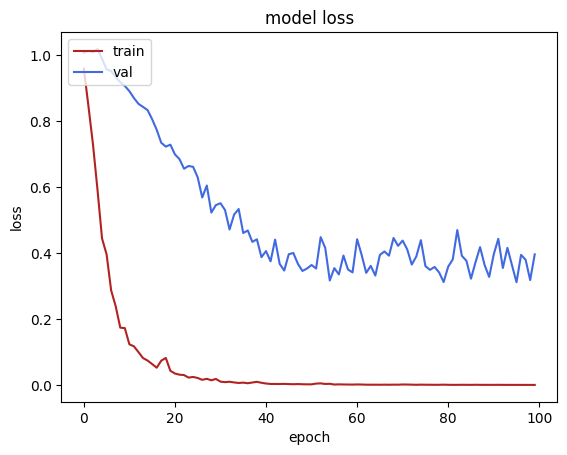

In [259]:
import matplotlib.pyplot as plt
plt.plot(historys['loss'],color='firebrick')
plt.plot(historys['val_loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

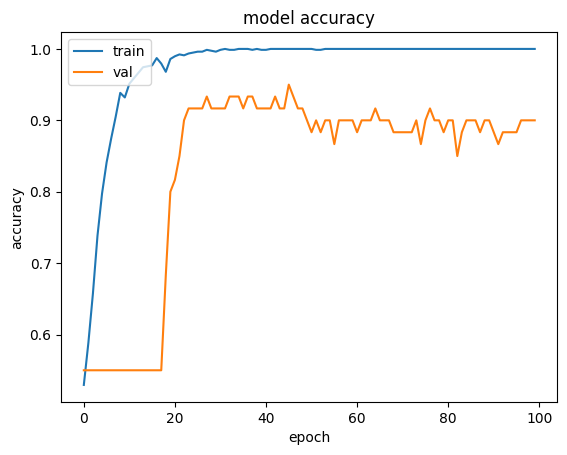

In [260]:
import matplotlib.pyplot as plt
plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [262]:
print(result_list)
np.average(result_list)

[]


nan

In [273]:
# Create directory to save models 

save_dir = './Models/'

historys = {}
NUM_shuf = 3
result_list = []

# Run each split
# for RUN in range(NUM_shuf):
# with tf.device('/device:GPU:0'): 

# CREATE NEW MODEL
# model = ensemble_build_model2()
model = build_model2()

# COMPILE NEW MODEL
model.compile(loss='hinge',optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['acc'])#BinaryCrossentropy

imgs_x     = train_DATA['MEL_Y']
imgs_y = train_DATA['1D_Y']
labels = np.array(train_DATA['LABEL'])

test_imgs_x    = test_DATA['MEL_Y']
test_imgs_y = test_DATA['1D_Y']
test_labels  = np.array(test_DATA['LABEL'])

# #generator for fusion model
# TRAIN      = Generator(imgs_x,imgs_y,labels,batch_size=60)
# TEST          = Generator(test_imgs_x,test_imgs_y,test_labels, batch_size=60)

#generator for 1d cnn model
TRAIN      = GeneratorC1d(imgs_y,labels,batch_size=60)
TEST          = GeneratorC1d(test_imgs_y,test_labels, batch_size=60)

# # generator for 2d cnn model
# TRAIN      = GeneratorC(imgs_x,labels,batch_size=60)
# TEST          = GeneratorC(test_imgs_x,test_labels, batch_size=60)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, mode = 'auto')
#     schedulers = tf.keras.callbacks.LearningRateScheduler(scheduler)

# CREATE CALLBACKS
checkpointer = keras.callbacks.ModelCheckpoint(save_dir+'Cls_VibY_V3.h5', verbose=1, save_best_only=True)

# FIT THE MODEL
history = model.fit_generator(TRAIN,
epochs=100,
validation_data=TEST,
callbacks=[checkpointer,early_stopping],use_multiprocessing = False)

historys= history.history

<ipython-input-273-2f849a9f1bc1>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(TRAIN,


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.0055 - acc: 0.5038
Epoch 00001: val_loss improved from inf to 0.99975, saving model to ./Models/Cls_VibY_V3.h5
13/13 [==============================] - 31s 2s/step - loss: 1.0055 - acc: 0.5038 - val_loss: 0.9997 - val_acc: 0.5500
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.9792 - acc: 0.5038
Epoch 00002: val_loss improved from 0.99975 to 0.99679, saving model to ./Models/Cls_VibY_V3.h5
13/13 [==============================] - 29s 2s/step - loss: 0.9792 - acc: 0.5038 - val_loss: 0.9968 - val_acc: 0.5500
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.8597 - acc: 0.5038
Epoch 00003: val_loss improved from 0.99679 to 0.99087, saving model to ./Models/Cls_VibY_V3.h5
13/13 [==============================] - 29s 2s/step - loss: 0.8597 - acc: 0.5038 - val_loss: 0.9909 - val_acc: 0.5500
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.7491 - acc: 0.5038

Epoch 57/100
13/13 [==============================] - ETA: 0s - loss: 0.0022 - acc: 1.0000
Epoch 00057: val_loss did not improve from 0.54400
13/13 [==============================] - 0s 28ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.5787 - val_acc: 0.7833
Epoch 58/100
13/13 [==============================] - ETA: 0s - loss: 0.0022 - acc: 1.0000
Epoch 00058: val_loss did not improve from 0.54400
13/13 [==============================] - 0s 27ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.5878 - val_acc: 0.7667
Epoch 59/100
13/13 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 00059: val_loss did not improve from 0.54400
13/13 [==============================] - 0s 27ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.5960 - val_acc: 0.7667
Epoch 60/100
13/13 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 00060: val_loss did not improve from 0.54400
13/13 [==============================] - 0s 27ms/step - loss: 0.0020 - a

Epoch 88/100
13/13 [==============================] - ETA: 0s - loss: 8.7721e-04 - acc: 1.0000
Epoch 00088: val_loss did not improve from 0.51275
13/13 [==============================] - 0s 27ms/step - loss: 8.7721e-04 - acc: 1.0000 - val_loss: 0.5934 - val_acc: 0.7500
Epoch 89/100
13/13 [==============================] - ETA: 0s - loss: 8.4727e-04 - acc: 1.0000
Epoch 00089: val_loss did not improve from 0.51275
13/13 [==============================] - 0s 27ms/step - loss: 8.4727e-04 - acc: 1.0000 - val_loss: 0.5712 - val_acc: 0.7667
Epoch 90/100
13/13 [==============================] - ETA: 0s - loss: 8.2272e-04 - acc: 1.0000
Epoch 00090: val_loss did not improve from 0.51275
13/13 [==============================] - 0s 27ms/step - loss: 8.2272e-04 - acc: 1.0000 - val_loss: 0.5756 - val_acc: 0.7667
Epoch 91/100
13/13 [==============================] - ETA: 0s - loss: 8.2394e-04 - acc: 1.0000
Epoch 00091: val_loss did not improve from 0.51275
13/13 [==============================] - 0s 

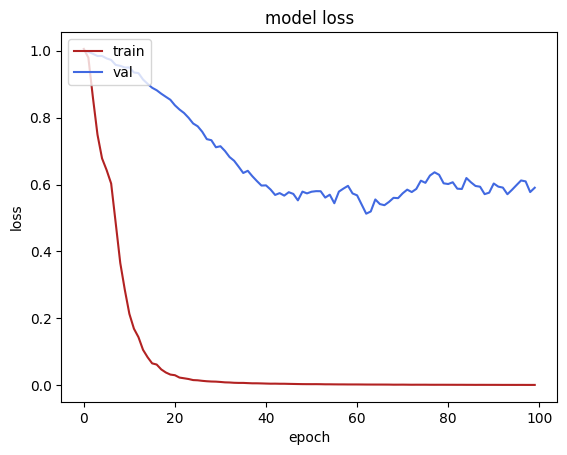

In [274]:
import matplotlib.pyplot as plt
plt.plot(historys['loss'],color='firebrick')
plt.plot(historys['val_loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

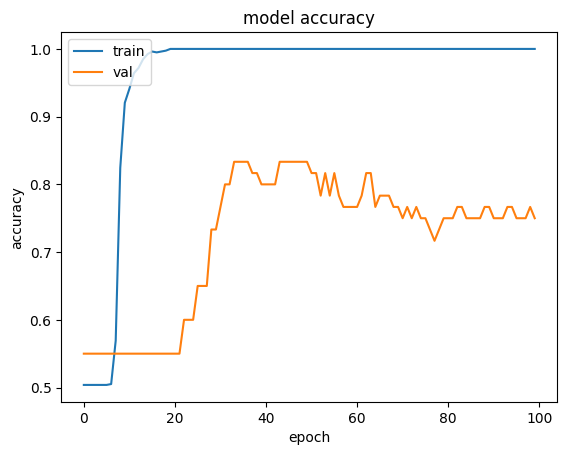

In [275]:
import matplotlib.pyplot as plt
plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [310]:
# Create directory to save models 

save_dir = './Models/'

historys = {}
NUM_shuf = 3
result_list = []

# Run each split
# for RUN in range(NUM_shuf):
# with tf.device('/device:GPU:0'): 

# CREATE NEW MODEL
model = ensemble_build_model2()
# model = build_model2()

# COMPILE NEW MODEL
model.compile(loss='hinge',optimizer=tf.keras.optimizers.Adam(0.00001),metrics=['acc'])#BinaryCrossentropy

imgs_x     = train_DATA['MEL_Y']
imgs_y = train_DATA['1D_Y']
labels = np.array(train_DATA['LABEL'])

test_imgs_x    = test_DATA['MEL_Y']
test_imgs_y = test_DATA['1D_Y']
test_labels  = np.array(test_DATA['LABEL'])

#generator for fusion model
TRAIN      = Generator(imgs_x,imgs_y,labels,batch_size=60)
TEST          = Generator(test_imgs_x,test_imgs_y,test_labels, batch_size=60)

# #generator for 1d cnn model
# TRAIN      = GeneratorC1d(imgs_y,labels,batch_size=60)
# TEST          = GeneratorC1d(test_imgs_y,test_labels, batch_size=60)

# # generator for 2d cnn model
# TRAIN      = GeneratorC(imgs_x,labels,batch_size=60)
# TEST          = GeneratorC(test_imgs_x,test_labels, batch_size=60)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1000,mode = 'auto')
#     schedulers = tf.keras.callbacks.LearningRateScheduler(scheduler)

# CREATE CALLBACKS
checkpointer = keras.callbacks.ModelCheckpoint(save_dir+'Cls_VibY_V4.h5', verbose=1, save_best_only=True)

# FIT THE MODEL
history = model.fit_generator(TRAIN,
epochs=2000,
validation_data=TEST,
callbacks=[checkpointer,early_stopping],use_multiprocessing = False)

historys= history.history

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_564/Tanh:0', description="created by layer 'dense_564'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_570/Tanh:0', description="created by layer 'dense_570'")


<ipython-input-310-d86a5c22c919>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(TRAIN,


Epoch 1/2000
13/13 [==============================] - ETA: 0s - loss: 1.0003 - acc: 0.5038
Epoch 00001: val_loss improved from inf to 0.99998, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 14s 919ms/step - loss: 1.0003 - acc: 0.5038 - val_loss: 1.0000 - val_acc: 0.5500
Epoch 2/2000
13/13 [==============================] - ETA: 0s - loss: 0.9998 - acc: 0.5038
Epoch 00002: val_loss improved from 0.99998 to 0.99995, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 865ms/step - loss: 0.9998 - acc: 0.5038 - val_loss: 0.9999 - val_acc: 0.5500
Epoch 3/2000
13/13 [==============================] - ETA: 0s - loss: 0.9994 - acc: 0.5038
Epoch 00003: val_loss improved from 0.99995 to 0.99993, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 870ms/step - loss: 0.9994 - acc: 0.5038 - val_loss: 0.9999 - val_acc: 0.5500
Epoch 4/2000
13/13 [==============================] - ETA: 0s - loss: 0.9989 

13/13 [==============================] - 11s 854ms/step - loss: 0.9702 - acc: 0.5038 - val_loss: 0.9959 - val_acc: 0.5500
Epoch 28/2000
13/13 [==============================] - ETA: 0s - loss: 0.9688 - acc: 0.5038
Epoch 00028: val_loss improved from 0.99586 to 0.99530, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 851ms/step - loss: 0.9688 - acc: 0.5038 - val_loss: 0.9953 - val_acc: 0.5500
Epoch 29/2000
13/13 [==============================] - ETA: 0s - loss: 0.9679 - acc: 0.5038
Epoch 00029: val_loss improved from 0.99530 to 0.99501, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 856ms/step - loss: 0.9679 - acc: 0.5038 - val_loss: 0.9950 - val_acc: 0.5500
Epoch 30/2000
13/13 [==============================] - ETA: 0s - loss: 0.9667 - acc: 0.5038
Epoch 00030: val_loss improved from 0.99501 to 0.99446, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 866ms/step - loss: 0.9667

13/13 [==============================] - 11s 856ms/step - loss: 0.9334 - acc: 0.5038 - val_loss: 0.9772 - val_acc: 0.5500
Epoch 55/2000
13/13 [==============================] - ETA: 0s - loss: 0.9337 - acc: 0.5038
Epoch 00055: val_loss improved from 0.97723 to 0.97631, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 862ms/step - loss: 0.9337 - acc: 0.5038 - val_loss: 0.9763 - val_acc: 0.5500
Epoch 56/2000
13/13 [==============================] - ETA: 0s - loss: 0.9319 - acc: 0.5038
Epoch 00056: val_loss improved from 0.97631 to 0.97594, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 10s 848ms/step - loss: 0.9319 - acc: 0.5038 - val_loss: 0.9759 - val_acc: 0.5500
Epoch 57/2000
13/13 [==============================] - ETA: 0s - loss: 0.9304 - acc: 0.5038
Epoch 00057: val_loss did not improve from 0.97594
13/13 [==============================] - 4s 309ms/step - loss: 0.9304 - acc: 0.5038 - val_loss: 0.9762 - val_acc: 0

13/13 [==============================] - 11s 862ms/step - loss: 0.9008 - acc: 0.5038 - val_loss: 0.9646 - val_acc: 0.5500
Epoch 82/2000
13/13 [==============================] - ETA: 0s - loss: 0.8993 - acc: 0.5038
Epoch 00082: val_loss did not improve from 0.96456
13/13 [==============================] - 4s 311ms/step - loss: 0.8993 - acc: 0.5038 - val_loss: 0.9647 - val_acc: 0.5500
Epoch 83/2000
13/13 [==============================] - ETA: 0s - loss: 0.8988 - acc: 0.5038
Epoch 00083: val_loss improved from 0.96456 to 0.96367, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 865ms/step - loss: 0.8988 - acc: 0.5038 - val_loss: 0.9637 - val_acc: 0.5500
Epoch 84/2000
13/13 [==============================] - ETA: 0s - loss: 0.8981 - acc: 0.5038
Epoch 00084: val_loss did not improve from 0.96367
13/13 [==============================] - 4s 312ms/step - loss: 0.8981 - acc: 0.5038 - val_loss: 0.9640 - val_acc: 0.5500
Epoch 85/2000
13/13 [===================

Epoch 110/2000
13/13 [==============================] - ETA: 0s - loss: 0.8693 - acc: 0.5038
Epoch 00110: val_loss did not improve from 0.95669
13/13 [==============================] - 4s 305ms/step - loss: 0.8693 - acc: 0.5038 - val_loss: 0.9572 - val_acc: 0.5500
Epoch 111/2000
13/13 [==============================] - ETA: 0s - loss: 0.8693 - acc: 0.5038
Epoch 00111: val_loss improved from 0.95669 to 0.95541, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 862ms/step - loss: 0.8693 - acc: 0.5038 - val_loss: 0.9554 - val_acc: 0.5500
Epoch 112/2000
13/13 [==============================] - ETA: 0s - loss: 0.8677 - acc: 0.5038
Epoch 00112: val_loss did not improve from 0.95541
13/13 [==============================] - 4s 302ms/step - loss: 0.8677 - acc: 0.5038 - val_loss: 0.9559 - val_acc: 0.5500
Epoch 113/2000
13/13 [==============================] - ETA: 0s - loss: 0.8673 - acc: 0.5038
Epoch 00113: val_loss did not improve from 0.95541
13/13 [========

Epoch 139/2000
13/13 [==============================] - ETA: 0s - loss: 0.8433 - acc: 0.5038
Epoch 00139: val_loss did not improve from 0.94524
13/13 [==============================] - 4s 319ms/step - loss: 0.8433 - acc: 0.5038 - val_loss: 0.9485 - val_acc: 0.5500
Epoch 140/2000
13/13 [==============================] - ETA: 0s - loss: 0.8430 - acc: 0.5038
Epoch 00140: val_loss improved from 0.94524 to 0.94439, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 10s 848ms/step - loss: 0.8430 - acc: 0.5038 - val_loss: 0.9444 - val_acc: 0.5500
Epoch 141/2000
13/13 [==============================] - ETA: 0s - loss: 0.8421 - acc: 0.5038
Epoch 00141: val_loss did not improve from 0.94439
13/13 [==============================] - 4s 314ms/step - loss: 0.8421 - acc: 0.5038 - val_loss: 0.9456 - val_acc: 0.5500
Epoch 142/2000
13/13 [==============================] - ETA: 0s - loss: 0.8405 - acc: 0.5038
Epoch 00142: val_loss did not improve from 0.94439
13/13 [========

Epoch 169/2000
13/13 [==============================] - ETA: 0s - loss: 0.8180 - acc: 0.5038
Epoch 00169: val_loss did not improve from 0.93662
13/13 [==============================] - 4s 313ms/step - loss: 0.8180 - acc: 0.5038 - val_loss: 0.9405 - val_acc: 0.5500
Epoch 170/2000
13/13 [==============================] - ETA: 0s - loss: 0.8173 - acc: 0.5038
Epoch 00170: val_loss did not improve from 0.93662
13/13 [==============================] - 4s 307ms/step - loss: 0.8173 - acc: 0.5038 - val_loss: 0.9394 - val_acc: 0.5500
Epoch 171/2000
13/13 [==============================] - ETA: 0s - loss: 0.8180 - acc: 0.5038
Epoch 00171: val_loss did not improve from 0.93662
13/13 [==============================] - 4s 308ms/step - loss: 0.8180 - acc: 0.5038 - val_loss: 0.9391 - val_acc: 0.5500
Epoch 172/2000
13/13 [==============================] - ETA: 0s - loss: 0.8166 - acc: 0.5038
Epoch 00172: val_loss improved from 0.93662 to 0.93487, saving model to ./Models/Cls_VibY_V4.h5
13/13 [=========

13/13 [==============================] - ETA: 0s - loss: 0.7941 - acc: 0.5038
Epoch 00199: val_loss did not improve from 0.92710
13/13 [==============================] - 4s 304ms/step - loss: 0.7941 - acc: 0.5038 - val_loss: 0.9321 - val_acc: 0.5500
Epoch 200/2000
13/13 [==============================] - ETA: 0s - loss: 0.7931 - acc: 0.5038
Epoch 00200: val_loss did not improve from 0.92710
13/13 [==============================] - 4s 312ms/step - loss: 0.7931 - acc: 0.5038 - val_loss: 0.9323 - val_acc: 0.5500
Epoch 201/2000
13/13 [==============================] - ETA: 0s - loss: 0.7938 - acc: 0.5038
Epoch 00201: val_loss did not improve from 0.92710
13/13 [==============================] - 4s 302ms/step - loss: 0.7938 - acc: 0.5038 - val_loss: 0.9312 - val_acc: 0.5500
Epoch 202/2000
13/13 [==============================] - ETA: 0s - loss: 0.7917 - acc: 0.5038
Epoch 00202: val_loss did not improve from 0.92710
13/13 [==============================] - 4s 303ms/step - loss: 0.7917 - acc:

Epoch 260/2000
13/13 [==============================] - ETA: 0s - loss: 0.7503 - acc: 0.5038
Epoch 00260: val_loss did not improve from 0.90657
13/13 [==============================] - 4s 308ms/step - loss: 0.7503 - acc: 0.5038 - val_loss: 0.9171 - val_acc: 0.5500
Epoch 261/2000
13/13 [==============================] - ETA: 0s - loss: 0.7489 - acc: 0.5038
Epoch 00261: val_loss did not improve from 0.90657
13/13 [==============================] - 4s 305ms/step - loss: 0.7489 - acc: 0.5038 - val_loss: 0.9074 - val_acc: 0.5500
Epoch 262/2000
13/13 [==============================] - ETA: 0s - loss: 0.7484 - acc: 0.5038
Epoch 00262: val_loss did not improve from 0.90657
13/13 [==============================] - 4s 311ms/step - loss: 0.7484 - acc: 0.5038 - val_loss: 0.9202 - val_acc: 0.5500
Epoch 263/2000
13/13 [==============================] - ETA: 0s - loss: 0.7476 - acc: 0.5038
Epoch 00263: val_loss did not improve from 0.90657
13/13 [==============================] - 4s 304ms/step - loss

13/13 [==============================] - ETA: 0s - loss: 0.7278 - acc: 0.5038
Epoch 00290: val_loss did not improve from 0.89393
13/13 [==============================] - 4s 310ms/step - loss: 0.7278 - acc: 0.5038 - val_loss: 0.9005 - val_acc: 0.5500
Epoch 291/2000
13/13 [==============================] - ETA: 0s - loss: 0.7272 - acc: 0.5038
Epoch 00291: val_loss did not improve from 0.89393
13/13 [==============================] - 4s 308ms/step - loss: 0.7272 - acc: 0.5038 - val_loss: 0.9035 - val_acc: 0.5500
Epoch 292/2000
13/13 [==============================] - ETA: 0s - loss: 0.7267 - acc: 0.5038
Epoch 00292: val_loss did not improve from 0.89393
13/13 [==============================] - 4s 308ms/step - loss: 0.7267 - acc: 0.5038 - val_loss: 0.8963 - val_acc: 0.5500
Epoch 293/2000
13/13 [==============================] - ETA: 0s - loss: 0.7260 - acc: 0.5038
Epoch 00293: val_loss did not improve from 0.89393
13/13 [==============================] - 4s 304ms/step - loss: 0.7260 - acc:

Epoch 321/2000
13/13 [==============================] - ETA: 0s - loss: 0.7068 - acc: 0.5038
Epoch 00321: val_loss did not improve from 0.88102
13/13 [==============================] - 4s 313ms/step - loss: 0.7068 - acc: 0.5038 - val_loss: 0.8988 - val_acc: 0.5500
Epoch 322/2000
13/13 [==============================] - ETA: 0s - loss: 0.7055 - acc: 0.5038
Epoch 00322: val_loss did not improve from 0.88102
13/13 [==============================] - 4s 303ms/step - loss: 0.7055 - acc: 0.5038 - val_loss: 0.8812 - val_acc: 0.5500
Epoch 323/2000
13/13 [==============================] - ETA: 0s - loss: 0.7049 - acc: 0.5038
Epoch 00323: val_loss did not improve from 0.88102
13/13 [==============================] - 4s 317ms/step - loss: 0.7049 - acc: 0.5038 - val_loss: 0.8938 - val_acc: 0.5500
Epoch 324/2000
13/13 [==============================] - ETA: 0s - loss: 0.7042 - acc: 0.5038
Epoch 00324: val_loss did not improve from 0.88102
13/13 [==============================] - 4s 314ms/step - loss

Epoch 352/2000
13/13 [==============================] - ETA: 0s - loss: 0.6853 - acc: 0.5038
Epoch 00352: val_loss did not improve from 0.87699
13/13 [==============================] - 4s 301ms/step - loss: 0.6853 - acc: 0.5038 - val_loss: 0.8823 - val_acc: 0.5500
Epoch 353/2000
13/13 [==============================] - ETA: 0s - loss: 0.6842 - acc: 0.5038
Epoch 00353: val_loss did not improve from 0.87699
13/13 [==============================] - 4s 304ms/step - loss: 0.6842 - acc: 0.5038 - val_loss: 0.8910 - val_acc: 0.5500
Epoch 354/2000
13/13 [==============================] - ETA: 0s - loss: 0.6833 - acc: 0.5038
Epoch 00354: val_loss did not improve from 0.87699
13/13 [==============================] - 4s 303ms/step - loss: 0.6833 - acc: 0.5038 - val_loss: 0.8919 - val_acc: 0.5500
Epoch 355/2000
13/13 [==============================] - ETA: 0s - loss: 0.6835 - acc: 0.5038
Epoch 00355: val_loss improved from 0.87699 to 0.87234, saving model to ./Models/Cls_VibY_V4.h5
13/13 [=========

Epoch 413/2000
13/13 [==============================] - ETA: 0s - loss: 0.6445 - acc: 0.5038
Epoch 00413: val_loss improved from 0.84781 to 0.84539, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 859ms/step - loss: 0.6445 - acc: 0.5038 - val_loss: 0.8454 - val_acc: 0.5500
Epoch 414/2000
13/13 [==============================] - ETA: 0s - loss: 0.6440 - acc: 0.5038
Epoch 00414: val_loss did not improve from 0.84539
13/13 [==============================] - 4s 313ms/step - loss: 0.6440 - acc: 0.5038 - val_loss: 0.8725 - val_acc: 0.5500
Epoch 415/2000
13/13 [==============================] - ETA: 0s - loss: 0.6429 - acc: 0.5038
Epoch 00415: val_loss did not improve from 0.84539
13/13 [==============================] - 4s 313ms/step - loss: 0.6429 - acc: 0.5038 - val_loss: 0.8733 - val_acc: 0.5500
Epoch 416/2000
13/13 [==============================] - ETA: 0s - loss: 0.6429 - acc: 0.5038
Epoch 00416: val_loss improved from 0.84539 to 0.84371, saving mod

Epoch 444/2000
13/13 [==============================] - ETA: 0s - loss: 0.6257 - acc: 0.5038
Epoch 00444: val_loss improved from 0.84218 to 0.83779, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 10s 847ms/step - loss: 0.6257 - acc: 0.5038 - val_loss: 0.8378 - val_acc: 0.5500
Epoch 445/2000
13/13 [==============================] - ETA: 0s - loss: 0.6232 - acc: 0.5038
Epoch 00445: val_loss did not improve from 0.83779
13/13 [==============================] - 4s 306ms/step - loss: 0.6232 - acc: 0.5038 - val_loss: 0.8407 - val_acc: 0.5500
Epoch 446/2000
13/13 [==============================] - ETA: 0s - loss: 0.6226 - acc: 0.5038
Epoch 00446: val_loss did not improve from 0.83779
13/13 [==============================] - 4s 306ms/step - loss: 0.6226 - acc: 0.5038 - val_loss: 0.8680 - val_acc: 0.5500
Epoch 447/2000
13/13 [==============================] - ETA: 0s - loss: 0.6216 - acc: 0.5038
Epoch 00447: val_loss did not improve from 0.83779
13/13 [========

13/13 [==============================] - ETA: 0s - loss: 0.5843 - acc: 0.5038
Epoch 00504: val_loss did not improve from 0.81219
13/13 [==============================] - 4s 307ms/step - loss: 0.5843 - acc: 0.5038 - val_loss: 0.8136 - val_acc: 0.5500
Epoch 505/2000
13/13 [==============================] - ETA: 0s - loss: 0.5830 - acc: 0.5038
Epoch 00505: val_loss did not improve from 0.81219
13/13 [==============================] - 6s 439ms/step - loss: 0.5830 - acc: 0.5038 - val_loss: 0.8362 - val_acc: 0.5500
Epoch 506/2000
13/13 [==============================] - ETA: 0s - loss: 0.5822 - acc: 0.5038
Epoch 00506: val_loss did not improve from 0.81219
13/13 [==============================] - 5s 375ms/step - loss: 0.5822 - acc: 0.5038 - val_loss: 0.8310 - val_acc: 0.5500
Epoch 507/2000
13/13 [==============================] - ETA: 0s - loss: 0.5815 - acc: 0.5038
Epoch 00507: val_loss did not improve from 0.81219
13/13 [==============================] - 4s 313ms/step - loss: 0.5815 - acc:

Epoch 535/2000
13/13 [==============================] - ETA: 0s - loss: 0.5596 - acc: 0.5038
Epoch 00535: val_loss did not improve from 0.80309
13/13 [==============================] - 4s 305ms/step - loss: 0.5596 - acc: 0.5038 - val_loss: 0.8048 - val_acc: 0.5500
Epoch 536/2000
13/13 [==============================] - ETA: 0s - loss: 0.5585 - acc: 0.5038
Epoch 00536: val_loss did not improve from 0.80309
13/13 [==============================] - 4s 303ms/step - loss: 0.5585 - acc: 0.5038 - val_loss: 0.8055 - val_acc: 0.5500
Epoch 537/2000
13/13 [==============================] - ETA: 0s - loss: 0.5578 - acc: 0.5038
Epoch 00537: val_loss did not improve from 0.80309
13/13 [==============================] - 4s 318ms/step - loss: 0.5578 - acc: 0.5038 - val_loss: 0.8045 - val_acc: 0.5500
Epoch 538/2000
13/13 [==============================] - ETA: 0s - loss: 0.5573 - acc: 0.5038
Epoch 00538: val_loss did not improve from 0.80309
13/13 [==============================] - 4s 303ms/step - loss

Epoch 564/2000
13/13 [==============================] - ETA: 0s - loss: 0.5326 - acc: 0.5038
Epoch 00564: val_loss improved from 0.79269 to 0.79104, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 864ms/step - loss: 0.5326 - acc: 0.5038 - val_loss: 0.7910 - val_acc: 0.5500
Epoch 565/2000
13/13 [==============================] - ETA: 0s - loss: 0.5315 - acc: 0.5038
Epoch 00565: val_loss improved from 0.79104 to 0.79091, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 860ms/step - loss: 0.5315 - acc: 0.5038 - val_loss: 0.7909 - val_acc: 0.5500
Epoch 566/2000
13/13 [==============================] - ETA: 0s - loss: 0.5306 - acc: 0.5038
Epoch 00566: val_loss did not improve from 0.79091
13/13 [==============================] - 4s 320ms/step - loss: 0.5306 - acc: 0.5038 - val_loss: 0.7910 - val_acc: 0.5500
Epoch 567/2000
13/13 [==============================] - ETA: 0s - loss: 0.5297 - acc: 0.5038
Epoch 00567: val_los

Epoch 593/2000
13/13 [==============================] - ETA: 0s - loss: 0.5065 - acc: 0.5038
Epoch 00593: val_loss did not improve from 0.78042
13/13 [==============================] - 4s 303ms/step - loss: 0.5065 - acc: 0.5038 - val_loss: 0.7816 - val_acc: 0.5500
Epoch 594/2000
13/13 [==============================] - ETA: 0s - loss: 0.5056 - acc: 0.5038
Epoch 00594: val_loss improved from 0.78042 to 0.77859, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 860ms/step - loss: 0.5056 - acc: 0.5038 - val_loss: 0.7786 - val_acc: 0.5500
Epoch 595/2000
13/13 [==============================] - ETA: 0s - loss: 0.5046 - acc: 0.5038
Epoch 00595: val_loss did not improve from 0.77859
13/13 [==============================] - 4s 305ms/step - loss: 0.5046 - acc: 0.5038 - val_loss: 0.7804 - val_acc: 0.5500
Epoch 596/2000
13/13 [==============================] - ETA: 0s - loss: 0.5037 - acc: 0.5038
Epoch 00596: val_loss improved from 0.77859 to 0.77830, saving mod

Epoch 622/2000
13/13 [==============================] - ETA: 0s - loss: 0.4823 - acc: 0.5038
Epoch 00622: val_loss did not improve from 0.76796
13/13 [==============================] - 4s 310ms/step - loss: 0.4823 - acc: 0.5038 - val_loss: 0.7682 - val_acc: 0.5500
Epoch 623/2000
13/13 [==============================] - ETA: 0s - loss: 0.4817 - acc: 0.5038
Epoch 00623: val_loss did not improve from 0.76796
13/13 [==============================] - 4s 306ms/step - loss: 0.4817 - acc: 0.5038 - val_loss: 0.7739 - val_acc: 0.5500
Epoch 624/2000
13/13 [==============================] - ETA: 0s - loss: 0.4809 - acc: 0.5038
Epoch 00624: val_loss improved from 0.76796 to 0.76679, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 861ms/step - loss: 0.4809 - acc: 0.5038 - val_loss: 0.7668 - val_acc: 0.5500
Epoch 625/2000
13/13 [==============================] - ETA: 0s - loss: 0.4802 - acc: 0.5038
Epoch 00625: val_loss did not improve from 0.76679
13/13 [========

13/13 [==============================] - 11s 860ms/step - loss: 0.4605 - acc: 0.5038 - val_loss: 0.7617 - val_acc: 0.5500
Epoch 652/2000
13/13 [==============================] - ETA: 0s - loss: 0.4598 - acc: 0.5038
Epoch 00652: val_loss did not improve from 0.76170
13/13 [==============================] - 4s 309ms/step - loss: 0.4598 - acc: 0.5038 - val_loss: 0.7629 - val_acc: 0.5500
Epoch 653/2000
13/13 [==============================] - ETA: 0s - loss: 0.4591 - acc: 0.5038
Epoch 00653: val_loss did not improve from 0.76170
13/13 [==============================] - 4s 316ms/step - loss: 0.4591 - acc: 0.5038 - val_loss: 0.7659 - val_acc: 0.5500
Epoch 654/2000
13/13 [==============================] - ETA: 0s - loss: 0.4583 - acc: 0.5038
Epoch 00654: val_loss did not improve from 0.76170
13/13 [==============================] - 4s 304ms/step - loss: 0.4583 - acc: 0.5038 - val_loss: 0.7627 - val_acc: 0.5500
Epoch 655/2000
13/13 [==============================] - ETA: 0s - loss: 0.4576 - ac

13/13 [==============================] - ETA: 0s - loss: 0.4190 - acc: 0.5038
Epoch 00711: val_loss did not improve from 0.74404
13/13 [==============================] - 4s 303ms/step - loss: 0.4190 - acc: 0.5038 - val_loss: 0.7469 - val_acc: 0.5500
Epoch 712/2000
13/13 [==============================] - ETA: 0s - loss: 0.4184 - acc: 0.5038
Epoch 00712: val_loss improved from 0.74404 to 0.74146, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 862ms/step - loss: 0.4184 - acc: 0.5038 - val_loss: 0.7415 - val_acc: 0.5500
Epoch 713/2000
13/13 [==============================] - ETA: 0s - loss: 0.4178 - acc: 0.5038
Epoch 00713: val_loss did not improve from 0.74146
13/13 [==============================] - 4s 304ms/step - loss: 0.4178 - acc: 0.5038 - val_loss: 0.7510 - val_acc: 0.5500
Epoch 714/2000
13/13 [==============================] - ETA: 0s - loss: 0.4171 - acc: 0.5038
Epoch 00714: val_loss did not improve from 0.74146
13/13 [=======================

Epoch 742/2000
13/13 [==============================] - ETA: 0s - loss: 0.3996 - acc: 0.5038
Epoch 00742: val_loss did not improve from 0.73907
13/13 [==============================] - 4s 302ms/step - loss: 0.3996 - acc: 0.5038 - val_loss: 0.7468 - val_acc: 0.5500
Epoch 743/2000
13/13 [==============================] - ETA: 0s - loss: 0.3990 - acc: 0.5038
Epoch 00743: val_loss did not improve from 0.73907
13/13 [==============================] - 4s 306ms/step - loss: 0.3990 - acc: 0.5038 - val_loss: 0.7499 - val_acc: 0.5500
Epoch 744/2000
13/13 [==============================] - ETA: 0s - loss: 0.3983 - acc: 0.5038
Epoch 00744: val_loss did not improve from 0.73907
13/13 [==============================] - 4s 311ms/step - loss: 0.3983 - acc: 0.5038 - val_loss: 0.7413 - val_acc: 0.5500
Epoch 745/2000
13/13 [==============================] - ETA: 0s - loss: 0.3978 - acc: 0.5038
Epoch 00745: val_loss did not improve from 0.73907
13/13 [==============================] - 4s 316ms/step - loss

Epoch 773/2000
13/13 [==============================] - ETA: 0s - loss: 0.3810 - acc: 0.5038
Epoch 00773: val_loss did not improve from 0.73413
13/13 [==============================] - 4s 306ms/step - loss: 0.3810 - acc: 0.5038 - val_loss: 0.7426 - val_acc: 0.5500
Epoch 774/2000
13/13 [==============================] - ETA: 0s - loss: 0.3804 - acc: 0.5038
Epoch 00774: val_loss did not improve from 0.73413
13/13 [==============================] - 4s 302ms/step - loss: 0.3804 - acc: 0.5038 - val_loss: 0.7522 - val_acc: 0.5500
Epoch 775/2000
13/13 [==============================] - ETA: 0s - loss: 0.3798 - acc: 0.5038
Epoch 00775: val_loss did not improve from 0.73413
13/13 [==============================] - 4s 311ms/step - loss: 0.3798 - acc: 0.5038 - val_loss: 0.7389 - val_acc: 0.5500
Epoch 776/2000
13/13 [==============================] - ETA: 0s - loss: 0.3793 - acc: 0.5038
Epoch 00776: val_loss did not improve from 0.73413
13/13 [==============================] - 4s 310ms/step - loss

Epoch 834/2000
13/13 [==============================] - ETA: 0s - loss: 0.3466 - acc: 0.5038
Epoch 00834: val_loss did not improve from 0.71945
13/13 [==============================] - 4s 304ms/step - loss: 0.3466 - acc: 0.5038 - val_loss: 0.7296 - val_acc: 0.5500
Epoch 835/2000
13/13 [==============================] - ETA: 0s - loss: 0.3461 - acc: 0.5038
Epoch 00835: val_loss did not improve from 0.71945
13/13 [==============================] - 4s 320ms/step - loss: 0.3461 - acc: 0.5038 - val_loss: 0.7411 - val_acc: 0.5500
Epoch 836/2000
13/13 [==============================] - ETA: 0s - loss: 0.3456 - acc: 0.5038
Epoch 00836: val_loss did not improve from 0.71945
13/13 [==============================] - 4s 306ms/step - loss: 0.3456 - acc: 0.5038 - val_loss: 0.7281 - val_acc: 0.5500
Epoch 837/2000
13/13 [==============================] - ETA: 0s - loss: 0.3451 - acc: 0.5038
Epoch 00837: val_loss did not improve from 0.71945
13/13 [==============================] - 4s 302ms/step - loss

Epoch 865/2000
13/13 [==============================] - ETA: 0s - loss: 0.3304 - acc: 1.0000
Epoch 00865: val_loss did not improve from 0.71669
13/13 [==============================] - 4s 312ms/step - loss: 0.3304 - acc: 1.0000 - val_loss: 0.7300 - val_acc: 0.7000
Epoch 866/2000
13/13 [==============================] - ETA: 0s - loss: 0.3300 - acc: 0.9987
Epoch 00866: val_loss did not improve from 0.71669
13/13 [==============================] - 4s 308ms/step - loss: 0.3300 - acc: 0.9987 - val_loss: 0.7470 - val_acc: 0.7333
Epoch 867/2000
13/13 [==============================] - ETA: 0s - loss: 0.3295 - acc: 1.0000
Epoch 00867: val_loss improved from 0.71669 to 0.71431, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 11s 880ms/step - loss: 0.3295 - acc: 1.0000 - val_loss: 0.7143 - val_acc: 0.6667
Epoch 868/2000
13/13 [==============================] - ETA: 0s - loss: 0.3289 - acc: 0.9987
Epoch 00868: val_loss did not improve from 0.71431
13/13 [========

Epoch 896/2000
13/13 [==============================] - ETA: 0s - loss: 0.3154 - acc: 1.0000
Epoch 00896: val_loss did not improve from 0.70857
13/13 [==============================] - 4s 320ms/step - loss: 0.3154 - acc: 1.0000 - val_loss: 0.7794 - val_acc: 0.7000
Epoch 897/2000
13/13 [==============================] - ETA: 0s - loss: 0.3149 - acc: 1.0000
Epoch 00897: val_loss did not improve from 0.70857
13/13 [==============================] - 4s 315ms/step - loss: 0.3149 - acc: 1.0000 - val_loss: 0.7520 - val_acc: 0.7167
Epoch 898/2000
13/13 [==============================] - ETA: 0s - loss: 0.3143 - acc: 1.0000
Epoch 00898: val_loss did not improve from 0.70857
13/13 [==============================] - 4s 306ms/step - loss: 0.3143 - acc: 1.0000 - val_loss: 0.7324 - val_acc: 0.7000
Epoch 899/2000
13/13 [==============================] - ETA: 0s - loss: 0.3139 - acc: 1.0000
Epoch 00899: val_loss did not improve from 0.70857
13/13 [==============================] - 4s 312ms/step - loss

Epoch 927/2000
13/13 [==============================] - ETA: 0s - loss: 0.3006 - acc: 1.0000
Epoch 00927: val_loss did not improve from 0.70621
13/13 [==============================] - 4s 309ms/step - loss: 0.3006 - acc: 1.0000 - val_loss: 0.7249 - val_acc: 0.7167
Epoch 928/2000
13/13 [==============================] - ETA: 0s - loss: 0.3001 - acc: 1.0000
Epoch 00928: val_loss did not improve from 0.70621
13/13 [==============================] - 4s 304ms/step - loss: 0.3001 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 0.7333
Epoch 929/2000
13/13 [==============================] - ETA: 0s - loss: 0.2997 - acc: 1.0000
Epoch 00929: val_loss did not improve from 0.70621
13/13 [==============================] - 4s 303ms/step - loss: 0.2997 - acc: 1.0000 - val_loss: 0.7215 - val_acc: 0.7167
Epoch 930/2000
13/13 [==============================] - ETA: 0s - loss: 0.2992 - acc: 1.0000
Epoch 00930: val_loss did not improve from 0.70621
13/13 [==============================] - 4s 303ms/step - loss

Epoch 958/2000
13/13 [==============================] - ETA: 0s - loss: 0.2864 - acc: 1.0000
Epoch 00958: val_loss did not improve from 0.69587
13/13 [==============================] - 4s 316ms/step - loss: 0.2864 - acc: 1.0000 - val_loss: 0.7128 - val_acc: 0.7167
Epoch 959/2000
13/13 [==============================] - ETA: 0s - loss: 0.2860 - acc: 1.0000
Epoch 00959: val_loss did not improve from 0.69587
13/13 [==============================] - 4s 308ms/step - loss: 0.2860 - acc: 1.0000 - val_loss: 0.7280 - val_acc: 0.7333
Epoch 960/2000
13/13 [==============================] - ETA: 0s - loss: 0.2855 - acc: 1.0000
Epoch 00960: val_loss did not improve from 0.69587
13/13 [==============================] - 4s 319ms/step - loss: 0.2855 - acc: 1.0000 - val_loss: 0.7147 - val_acc: 0.7167
Epoch 961/2000
13/13 [==============================] - ETA: 0s - loss: 0.2851 - acc: 1.0000
Epoch 00961: val_loss did not improve from 0.69587
13/13 [==============================] - 4s 306ms/step - loss

Epoch 989/2000
13/13 [==============================] - ETA: 0s - loss: 0.2727 - acc: 1.0000
Epoch 00989: val_loss did not improve from 0.68823
13/13 [==============================] - 4s 307ms/step - loss: 0.2727 - acc: 1.0000 - val_loss: 0.7471 - val_acc: 0.7333
Epoch 990/2000
13/13 [==============================] - ETA: 0s - loss: 0.2723 - acc: 1.0000
Epoch 00990: val_loss did not improve from 0.68823
13/13 [==============================] - 4s 316ms/step - loss: 0.2723 - acc: 1.0000 - val_loss: 0.7159 - val_acc: 0.7333
Epoch 991/2000
13/13 [==============================] - ETA: 0s - loss: 0.2718 - acc: 1.0000
Epoch 00991: val_loss did not improve from 0.68823
13/13 [==============================] - 4s 316ms/step - loss: 0.2718 - acc: 1.0000 - val_loss: 0.7279 - val_acc: 0.7167
Epoch 992/2000
13/13 [==============================] - ETA: 0s - loss: 0.2713 - acc: 1.0000
Epoch 00992: val_loss did not improve from 0.68823
13/13 [==============================] - 4s 338ms/step - loss

Epoch 1020/2000
13/13 [==============================] - ETA: 0s - loss: 0.2594 - acc: 1.0000
Epoch 01020: val_loss did not improve from 0.67914
13/13 [==============================] - 4s 311ms/step - loss: 0.2594 - acc: 1.0000 - val_loss: 0.7129 - val_acc: 0.7333
Epoch 1021/2000
13/13 [==============================] - ETA: 0s - loss: 0.2589 - acc: 1.0000
Epoch 01021: val_loss did not improve from 0.67914
13/13 [==============================] - 4s 311ms/step - loss: 0.2589 - acc: 1.0000 - val_loss: 0.7230 - val_acc: 0.7333
Epoch 1022/2000
13/13 [==============================] - ETA: 0s - loss: 0.2585 - acc: 1.0000
Epoch 01022: val_loss did not improve from 0.67914
13/13 [==============================] - 4s 312ms/step - loss: 0.2585 - acc: 1.0000 - val_loss: 0.7239 - val_acc: 0.7333
Epoch 1023/2000
13/13 [==============================] - ETA: 0s - loss: 0.2581 - acc: 1.0000
Epoch 01023: val_loss did not improve from 0.67914
13/13 [==============================] - 4s 306ms/step - 

Epoch 1051/2000
13/13 [==============================] - ETA: 0s - loss: 0.2466 - acc: 1.0000
Epoch 01051: val_loss did not improve from 0.67281
13/13 [==============================] - 4s 302ms/step - loss: 0.2466 - acc: 1.0000 - val_loss: 0.7347 - val_acc: 0.7167
Epoch 1052/2000
13/13 [==============================] - ETA: 0s - loss: 0.2462 - acc: 1.0000
Epoch 01052: val_loss did not improve from 0.67281
13/13 [==============================] - 4s 311ms/step - loss: 0.2462 - acc: 1.0000 - val_loss: 0.7166 - val_acc: 0.7333
Epoch 1053/2000
13/13 [==============================] - ETA: 0s - loss: 0.2458 - acc: 1.0000
Epoch 01053: val_loss did not improve from 0.67281
13/13 [==============================] - 4s 304ms/step - loss: 0.2458 - acc: 1.0000 - val_loss: 0.7092 - val_acc: 0.7333
Epoch 1054/2000
13/13 [==============================] - ETA: 0s - loss: 0.2454 - acc: 1.0000
Epoch 01054: val_loss did not improve from 0.67281
13/13 [==============================] - 4s 318ms/step - 

Epoch 1082/2000
13/13 [==============================] - ETA: 0s - loss: 0.2345 - acc: 1.0000
Epoch 01082: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 305ms/step - loss: 0.2345 - acc: 1.0000 - val_loss: 0.7267 - val_acc: 0.7167
Epoch 1083/2000
13/13 [==============================] - ETA: 0s - loss: 0.2341 - acc: 1.0000
Epoch 01083: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 305ms/step - loss: 0.2341 - acc: 1.0000 - val_loss: 0.7221 - val_acc: 0.7333
Epoch 1084/2000
13/13 [==============================] - ETA: 0s - loss: 0.2337 - acc: 1.0000
Epoch 01084: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 306ms/step - loss: 0.2337 - acc: 1.0000 - val_loss: 0.7476 - val_acc: 0.6833
Epoch 1085/2000
13/13 [==============================] - ETA: 0s - loss: 0.2333 - acc: 1.0000
Epoch 01085: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 314ms/step - 

Epoch 1113/2000
13/13 [==============================] - ETA: 0s - loss: 0.2228 - acc: 1.0000
Epoch 01113: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 313ms/step - loss: 0.2228 - acc: 1.0000 - val_loss: 0.7281 - val_acc: 0.7000
Epoch 1114/2000
13/13 [==============================] - ETA: 0s - loss: 0.2225 - acc: 1.0000
Epoch 01114: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 305ms/step - loss: 0.2225 - acc: 1.0000 - val_loss: 0.7101 - val_acc: 0.7333
Epoch 1115/2000
13/13 [==============================] - ETA: 0s - loss: 0.2221 - acc: 1.0000
Epoch 01115: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 303ms/step - loss: 0.2221 - acc: 1.0000 - val_loss: 0.7245 - val_acc: 0.7000
Epoch 1116/2000
13/13 [==============================] - ETA: 0s - loss: 0.2217 - acc: 1.0000
Epoch 01116: val_loss did not improve from 0.66976
13/13 [==============================] - 4s 311ms/step - 

Epoch 1144/2000
13/13 [==============================] - ETA: 0s - loss: 0.2116 - acc: 1.0000
Epoch 01144: val_loss did not improve from 0.66690
13/13 [==============================] - 4s 316ms/step - loss: 0.2116 - acc: 1.0000 - val_loss: 0.7071 - val_acc: 0.7500
Epoch 1145/2000
13/13 [==============================] - ETA: 0s - loss: 0.2112 - acc: 1.0000
Epoch 01145: val_loss did not improve from 0.66690
13/13 [==============================] - 4s 323ms/step - loss: 0.2112 - acc: 1.0000 - val_loss: 0.7289 - val_acc: 0.7000
Epoch 1146/2000
13/13 [==============================] - ETA: 0s - loss: 0.2109 - acc: 1.0000
Epoch 01146: val_loss did not improve from 0.66690
13/13 [==============================] - 4s 302ms/step - loss: 0.2109 - acc: 1.0000 - val_loss: 0.7753 - val_acc: 0.6833
Epoch 1147/2000
13/13 [==============================] - ETA: 0s - loss: 0.2105 - acc: 1.0000
Epoch 01147: val_loss improved from 0.66690 to 0.65856, saving model to ./Models/Cls_VibY_V4.h5
13/13 [=====

Epoch 1205/2000
13/13 [==============================] - ETA: 0s - loss: 0.1911 - acc: 1.0000
Epoch 01205: val_loss did not improve from 0.64186
13/13 [==============================] - 4s 307ms/step - loss: 0.1911 - acc: 1.0000 - val_loss: 0.7087 - val_acc: 0.7167
Epoch 1206/2000
13/13 [==============================] - ETA: 0s - loss: 0.1908 - acc: 1.0000
Epoch 01206: val_loss did not improve from 0.64186
13/13 [==============================] - 4s 305ms/step - loss: 0.1908 - acc: 1.0000 - val_loss: 0.7086 - val_acc: 0.7167
Epoch 1207/2000
13/13 [==============================] - ETA: 0s - loss: 0.1905 - acc: 1.0000
Epoch 01207: val_loss did not improve from 0.64186
13/13 [==============================] - 4s 306ms/step - loss: 0.1905 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.7167
Epoch 1208/2000
13/13 [==============================] - ETA: 0s - loss: 0.1902 - acc: 1.0000
Epoch 01208: val_loss did not improve from 0.64186
13/13 [==============================] - 4s 307ms/step - 

Epoch 1236/2000
13/13 [==============================] - ETA: 0s - loss: 0.1815 - acc: 1.0000
Epoch 01236: val_loss did not improve from 0.63560
13/13 [==============================] - 4s 302ms/step - loss: 0.1815 - acc: 1.0000 - val_loss: 0.7236 - val_acc: 0.6833
Epoch 1237/2000
13/13 [==============================] - ETA: 0s - loss: 0.1813 - acc: 1.0000
Epoch 01237: val_loss did not improve from 0.63560
13/13 [==============================] - 4s 310ms/step - loss: 0.1813 - acc: 1.0000 - val_loss: 0.6771 - val_acc: 0.7333
Epoch 1238/2000
13/13 [==============================] - ETA: 0s - loss: 0.1809 - acc: 1.0000
Epoch 01238: val_loss did not improve from 0.63560
13/13 [==============================] - 4s 303ms/step - loss: 0.1809 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.7167
Epoch 1239/2000
13/13 [==============================] - ETA: 0s - loss: 0.1807 - acc: 1.0000
Epoch 01239: val_loss did not improve from 0.63560
13/13 [==============================] - 4s 322ms/step - 

Epoch 1267/2000
13/13 [==============================] - ETA: 0s - loss: 0.1724 - acc: 1.0000
Epoch 01267: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 315ms/step - loss: 0.1724 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.7167
Epoch 1268/2000
13/13 [==============================] - ETA: 0s - loss: 0.1721 - acc: 1.0000
Epoch 01268: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 309ms/step - loss: 0.1721 - acc: 1.0000 - val_loss: 0.7080 - val_acc: 0.7000
Epoch 1269/2000
13/13 [==============================] - ETA: 0s - loss: 0.1718 - acc: 1.0000
Epoch 01269: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 325ms/step - loss: 0.1718 - acc: 1.0000 - val_loss: 0.6735 - val_acc: 0.7333
Epoch 1270/2000
13/13 [==============================] - ETA: 0s - loss: 0.1716 - acc: 1.0000
Epoch 01270: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 305ms/step - 

Epoch 1298/2000
13/13 [==============================] - ETA: 0s - loss: 0.1636 - acc: 1.0000
Epoch 01298: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 315ms/step - loss: 0.1636 - acc: 1.0000 - val_loss: 0.6847 - val_acc: 0.7000
Epoch 1299/2000
13/13 [==============================] - ETA: 0s - loss: 0.1634 - acc: 1.0000
Epoch 01299: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 311ms/step - loss: 0.1634 - acc: 1.0000 - val_loss: 0.6852 - val_acc: 0.7000
Epoch 1300/2000
13/13 [==============================] - ETA: 0s - loss: 0.1631 - acc: 1.0000
Epoch 01300: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 309ms/step - loss: 0.1631 - acc: 1.0000 - val_loss: 0.6688 - val_acc: 0.7167
Epoch 1301/2000
13/13 [==============================] - ETA: 0s - loss: 0.1628 - acc: 1.0000
Epoch 01301: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 322ms/step - 

Epoch 1329/2000
13/13 [==============================] - ETA: 0s - loss: 0.1552 - acc: 1.0000
Epoch 01329: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 325ms/step - loss: 0.1552 - acc: 1.0000 - val_loss: 0.7556 - val_acc: 0.7000
Epoch 1330/2000
13/13 [==============================] - ETA: 0s - loss: 0.1549 - acc: 1.0000
Epoch 01330: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 309ms/step - loss: 0.1549 - acc: 1.0000 - val_loss: 0.7009 - val_acc: 0.7000
Epoch 1331/2000
13/13 [==============================] - ETA: 0s - loss: 0.1546 - acc: 1.0000
Epoch 01331: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 312ms/step - loss: 0.1546 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.7000
Epoch 1332/2000
13/13 [==============================] - ETA: 0s - loss: 0.1544 - acc: 1.0000
Epoch 01332: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 339ms/step - 

Epoch 1360/2000
13/13 [==============================] - ETA: 0s - loss: 0.1470 - acc: 1.0000
Epoch 01360: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 304ms/step - loss: 0.1470 - acc: 1.0000 - val_loss: 0.6381 - val_acc: 0.7167
Epoch 1361/2000
13/13 [==============================] - ETA: 0s - loss: 0.1468 - acc: 1.0000
Epoch 01361: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 306ms/step - loss: 0.1468 - acc: 1.0000 - val_loss: 0.6725 - val_acc: 0.7000
Epoch 1362/2000
13/13 [==============================] - ETA: 0s - loss: 0.1465 - acc: 1.0000
Epoch 01362: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 312ms/step - loss: 0.1465 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 0.7167
Epoch 1363/2000
13/13 [==============================] - ETA: 0s - loss: 0.1463 - acc: 1.0000
Epoch 01363: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 313ms/step - 

Epoch 1391/2000
13/13 [==============================] - ETA: 0s - loss: 0.1392 - acc: 1.0000
Epoch 01391: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 305ms/step - loss: 0.1392 - acc: 1.0000 - val_loss: 0.6823 - val_acc: 0.7000
Epoch 1392/2000
13/13 [==============================] - ETA: 0s - loss: 0.1390 - acc: 1.0000
Epoch 01392: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 309ms/step - loss: 0.1390 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.7167
Epoch 1393/2000
13/13 [==============================] - ETA: 0s - loss: 0.1388 - acc: 1.0000
Epoch 01393: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 320ms/step - loss: 0.1388 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.7000
Epoch 1394/2000
13/13 [==============================] - ETA: 0s - loss: 0.1385 - acc: 1.0000
Epoch 01394: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 302ms/step - 

Epoch 1422/2000
13/13 [==============================] - ETA: 0s - loss: 0.1318 - acc: 1.0000
Epoch 01422: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 301ms/step - loss: 0.1318 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.7000
Epoch 1423/2000
13/13 [==============================] - ETA: 0s - loss: 0.1315 - acc: 1.0000
Epoch 01423: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 301ms/step - loss: 0.1315 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.7000
Epoch 1424/2000
13/13 [==============================] - ETA: 0s - loss: 0.1313 - acc: 1.0000
Epoch 01424: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 300ms/step - loss: 0.1313 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.7000
Epoch 1425/2000
13/13 [==============================] - ETA: 0s - loss: 0.1311 - acc: 1.0000
Epoch 01425: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 307ms/step - 

Epoch 1453/2000
13/13 [==============================] - ETA: 0s - loss: 0.1246 - acc: 1.0000
Epoch 01453: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 305ms/step - loss: 0.1246 - acc: 1.0000 - val_loss: 0.6609 - val_acc: 0.7000
Epoch 1454/2000
13/13 [==============================] - ETA: 0s - loss: 0.1244 - acc: 1.0000
Epoch 01454: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 303ms/step - loss: 0.1244 - acc: 1.0000 - val_loss: 0.6636 - val_acc: 0.7000
Epoch 1455/2000
13/13 [==============================] - ETA: 0s - loss: 0.1242 - acc: 1.0000
Epoch 01455: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 305ms/step - loss: 0.1242 - acc: 1.0000 - val_loss: 0.6531 - val_acc: 0.7000
Epoch 1456/2000
13/13 [==============================] - ETA: 0s - loss: 0.1239 - acc: 1.0000
Epoch 01456: val_loss did not improve from 0.62471
13/13 [==============================] - 4s 305ms/step - 

Epoch 1484/2000
13/13 [==============================] - ETA: 0s - loss: 0.1178 - acc: 1.0000
Epoch 01484: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 306ms/step - loss: 0.1178 - acc: 1.0000 - val_loss: 0.6628 - val_acc: 0.7000
Epoch 1485/2000
13/13 [==============================] - ETA: 0s - loss: 0.1175 - acc: 1.0000
Epoch 01485: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 315ms/step - loss: 0.1175 - acc: 1.0000 - val_loss: 0.6428 - val_acc: 0.7167
Epoch 1486/2000
13/13 [==============================] - ETA: 0s - loss: 0.1173 - acc: 1.0000
Epoch 01486: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 306ms/step - loss: 0.1173 - acc: 1.0000 - val_loss: 0.6751 - val_acc: 0.7000
Epoch 1487/2000
13/13 [==============================] - ETA: 0s - loss: 0.1171 - acc: 1.0000
Epoch 01487: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 303ms/step - 

Epoch 1515/2000
13/13 [==============================] - ETA: 0s - loss: 0.1113 - acc: 1.0000
Epoch 01515: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 304ms/step - loss: 0.1113 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.7000
Epoch 1516/2000
13/13 [==============================] - ETA: 0s - loss: 0.1110 - acc: 1.0000
Epoch 01516: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 304ms/step - loss: 0.1110 - acc: 1.0000 - val_loss: 0.6517 - val_acc: 0.7167
Epoch 1517/2000
13/13 [==============================] - ETA: 0s - loss: 0.1108 - acc: 1.0000
Epoch 01517: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 319ms/step - loss: 0.1108 - acc: 1.0000 - val_loss: 0.7164 - val_acc: 0.6833
Epoch 1518/2000
13/13 [==============================] - ETA: 0s - loss: 0.1106 - acc: 1.0000
Epoch 01518: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 304ms/step - 

Epoch 1546/2000
13/13 [==============================] - ETA: 0s - loss: 0.1050 - acc: 1.0000
Epoch 01546: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 307ms/step - loss: 0.1050 - acc: 1.0000 - val_loss: 0.6456 - val_acc: 0.7000
Epoch 1547/2000
13/13 [==============================] - ETA: 0s - loss: 0.1048 - acc: 1.0000
Epoch 01547: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 302ms/step - loss: 0.1048 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.6833
Epoch 1548/2000
13/13 [==============================] - ETA: 0s - loss: 0.1046 - acc: 1.0000
Epoch 01548: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 301ms/step - loss: 0.1046 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 0.6833
Epoch 1549/2000
13/13 [==============================] - ETA: 0s - loss: 0.1044 - acc: 1.0000
Epoch 01549: val_loss did not improve from 0.61309
13/13 [==============================] - 4s 303ms/step - 

Epoch 1577/2000
13/13 [==============================] - ETA: 0s - loss: 0.0990 - acc: 1.0000
Epoch 01577: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 327ms/step - loss: 0.0990 - acc: 1.0000 - val_loss: 0.6405 - val_acc: 0.7167
Epoch 1578/2000
13/13 [==============================] - ETA: 0s - loss: 0.0988 - acc: 1.0000
Epoch 01578: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 329ms/step - loss: 0.0988 - acc: 1.0000 - val_loss: 0.6550 - val_acc: 0.7000
Epoch 1579/2000
13/13 [==============================] - ETA: 0s - loss: 0.0987 - acc: 1.0000
Epoch 01579: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 326ms/step - loss: 0.0987 - acc: 1.0000 - val_loss: 0.6740 - val_acc: 0.7000
Epoch 1580/2000
13/13 [==============================] - ETA: 0s - loss: 0.0985 - acc: 1.0000
Epoch 01580: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 335ms/step - 

Epoch 1608/2000
13/13 [==============================] - ETA: 0s - loss: 0.0933 - acc: 1.0000
Epoch 01608: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 308ms/step - loss: 0.0933 - acc: 1.0000 - val_loss: 0.6768 - val_acc: 0.7000
Epoch 1609/2000
13/13 [==============================] - ETA: 0s - loss: 0.0932 - acc: 1.0000
Epoch 01609: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 328ms/step - loss: 0.0932 - acc: 1.0000 - val_loss: 0.6552 - val_acc: 0.7000
Epoch 1610/2000
13/13 [==============================] - ETA: 0s - loss: 0.0930 - acc: 1.0000
Epoch 01610: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 309ms/step - loss: 0.0930 - acc: 1.0000 - val_loss: 0.6430 - val_acc: 0.7167
Epoch 1611/2000
13/13 [==============================] - ETA: 0s - loss: 0.0928 - acc: 1.0000
Epoch 01611: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 313ms/step - 

Epoch 1639/2000
13/13 [==============================] - ETA: 0s - loss: 0.0880 - acc: 1.0000
Epoch 01639: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 311ms/step - loss: 0.0880 - acc: 1.0000 - val_loss: 0.6751 - val_acc: 0.7000
Epoch 1640/2000
13/13 [==============================] - ETA: 0s - loss: 0.0878 - acc: 1.0000
Epoch 01640: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 301ms/step - loss: 0.0878 - acc: 1.0000 - val_loss: 0.6516 - val_acc: 0.7000
Epoch 1641/2000
13/13 [==============================] - ETA: 0s - loss: 0.0876 - acc: 1.0000
Epoch 01641: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 304ms/step - loss: 0.0876 - acc: 1.0000 - val_loss: 0.6608 - val_acc: 0.7000
Epoch 1642/2000
13/13 [==============================] - ETA: 0s - loss: 0.0875 - acc: 1.0000
Epoch 01642: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 304ms/step - 

Epoch 1670/2000
13/13 [==============================] - ETA: 0s - loss: 0.0828 - acc: 1.0000
Epoch 01670: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 311ms/step - loss: 0.0828 - acc: 1.0000 - val_loss: 0.6859 - val_acc: 0.6833
Epoch 1671/2000
13/13 [==============================] - ETA: 0s - loss: 0.0827 - acc: 1.0000
Epoch 01671: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 305ms/step - loss: 0.0827 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.6833
Epoch 1672/2000
13/13 [==============================] - ETA: 0s - loss: 0.0825 - acc: 1.0000
Epoch 01672: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 309ms/step - loss: 0.0825 - acc: 1.0000 - val_loss: 0.6758 - val_acc: 0.7000
Epoch 1673/2000
13/13 [==============================] - ETA: 0s - loss: 0.0824 - acc: 1.0000
Epoch 01673: val_loss did not improve from 0.59449
13/13 [==============================] - 4s 304ms/step - 

Epoch 1701/2000
13/13 [==============================] - ETA: 0s - loss: 0.0780 - acc: 1.0000
Epoch 01701: val_loss did not improve from 0.58693
13/13 [==============================] - 4s 333ms/step - loss: 0.0780 - acc: 1.0000 - val_loss: 0.6770 - val_acc: 0.7000
Epoch 1702/2000
13/13 [==============================] - ETA: 0s - loss: 0.0778 - acc: 1.0000
Epoch 01702: val_loss improved from 0.58693 to 0.58571, saving model to ./Models/Cls_VibY_V4.h5
13/13 [==============================] - 12s 951ms/step - loss: 0.0778 - acc: 1.0000 - val_loss: 0.5857 - val_acc: 0.7333
Epoch 1703/2000
13/13 [==============================] - ETA: 0s - loss: 0.0777 - acc: 1.0000
Epoch 01703: val_loss did not improve from 0.58571
13/13 [==============================] - 4s 330ms/step - loss: 0.0777 - acc: 1.0000 - val_loss: 0.6599 - val_acc: 0.7000
Epoch 1704/2000
13/13 [==============================] - ETA: 0s - loss: 0.0775 - acc: 1.0000
Epoch 01704: val_loss did not improve from 0.58571
13/13 [====

Epoch 1732/2000
13/13 [==============================] - ETA: 0s - loss: 0.0733 - acc: 1.0000
Epoch 01732: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 322ms/step - loss: 0.0733 - acc: 1.0000 - val_loss: 0.7796 - val_acc: 0.6333
Epoch 1733/2000
13/13 [==============================] - ETA: 0s - loss: 0.0732 - acc: 1.0000
Epoch 01733: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 320ms/step - loss: 0.0732 - acc: 1.0000 - val_loss: 0.6654 - val_acc: 0.7000
Epoch 1734/2000
13/13 [==============================] - ETA: 0s - loss: 0.0730 - acc: 1.0000
Epoch 01734: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 305ms/step - loss: 0.0730 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.7000
Epoch 1735/2000
13/13 [==============================] - ETA: 0s - loss: 0.0729 - acc: 1.0000
Epoch 01735: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 304ms/step - 

Epoch 1763/2000
13/13 [==============================] - ETA: 0s - loss: 0.0689 - acc: 1.0000
Epoch 01763: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 319ms/step - loss: 0.0689 - acc: 1.0000 - val_loss: 0.6219 - val_acc: 0.7167
Epoch 1764/2000
13/13 [==============================] - ETA: 0s - loss: 0.0688 - acc: 1.0000
Epoch 01764: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 302ms/step - loss: 0.0688 - acc: 1.0000 - val_loss: 0.6725 - val_acc: 0.7000
Epoch 1765/2000
13/13 [==============================] - ETA: 0s - loss: 0.0687 - acc: 1.0000
Epoch 01765: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 315ms/step - loss: 0.0687 - acc: 1.0000 - val_loss: 0.6821 - val_acc: 0.6833
Epoch 1766/2000
13/13 [==============================] - ETA: 0s - loss: 0.0685 - acc: 1.0000
Epoch 01766: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 307ms/step - 

Epoch 1794/2000
13/13 [==============================] - ETA: 0s - loss: 0.0648 - acc: 1.0000
Epoch 01794: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 304ms/step - loss: 0.0648 - acc: 1.0000 - val_loss: 0.6630 - val_acc: 0.7000
Epoch 1795/2000
13/13 [==============================] - ETA: 0s - loss: 0.0646 - acc: 1.0000
Epoch 01795: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 304ms/step - loss: 0.0646 - acc: 1.0000 - val_loss: 0.6634 - val_acc: 0.7000
Epoch 1796/2000
13/13 [==============================] - ETA: 0s - loss: 0.0645 - acc: 1.0000
Epoch 01796: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 307ms/step - loss: 0.0645 - acc: 1.0000 - val_loss: 0.6676 - val_acc: 0.7000
Epoch 1797/2000
13/13 [==============================] - ETA: 0s - loss: 0.0644 - acc: 1.0000
Epoch 01797: val_loss did not improve from 0.58044
13/13 [==============================] - 4s 318ms/step - 

Epoch 1825/2000
13/13 [==============================] - ETA: 0s - loss: 0.0764 - acc: 0.9949
Epoch 01825: val_loss did not improve from 0.57036
13/13 [==============================] - 4s 302ms/step - loss: 0.0764 - acc: 0.9949 - val_loss: 0.5855 - val_acc: 0.7000
Epoch 1826/2000
13/13 [==============================] - ETA: 0s - loss: 0.0671 - acc: 0.9974
Epoch 01826: val_loss did not improve from 0.57036
13/13 [==============================] - 4s 304ms/step - loss: 0.0671 - acc: 0.9974 - val_loss: 0.6355 - val_acc: 0.6833
Epoch 1827/2000
13/13 [==============================] - ETA: 0s - loss: 0.0606 - acc: 1.0000
Epoch 01827: val_loss did not improve from 0.57036
13/13 [==============================] - 4s 313ms/step - loss: 0.0606 - acc: 1.0000 - val_loss: 0.8523 - val_acc: 0.5667
Epoch 1828/2000
13/13 [==============================] - ETA: 0s - loss: 0.0607 - acc: 1.0000
Epoch 01828: val_loss did not improve from 0.57036
13/13 [==============================] - 4s 303ms/step - 

Epoch 1855/2000
13/13 [==============================] - ETA: 0s - loss: 0.0572 - acc: 1.0000
Epoch 01855: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 308ms/step - loss: 0.0572 - acc: 1.0000 - val_loss: 0.5654 - val_acc: 0.7333
Epoch 1856/2000
13/13 [==============================] - ETA: 0s - loss: 0.0571 - acc: 1.0000
Epoch 01856: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 303ms/step - loss: 0.0571 - acc: 1.0000 - val_loss: 0.5657 - val_acc: 0.7333
Epoch 1857/2000
13/13 [==============================] - ETA: 0s - loss: 0.0570 - acc: 1.0000
Epoch 01857: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 305ms/step - loss: 0.0570 - acc: 1.0000 - val_loss: 0.5671 - val_acc: 0.7500
Epoch 1858/2000
13/13 [==============================] - ETA: 0s - loss: 0.0568 - acc: 1.0000
Epoch 01858: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 328ms/step - 

Epoch 1886/2000
13/13 [==============================] - ETA: 0s - loss: 0.0537 - acc: 1.0000
Epoch 01886: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 338ms/step - loss: 0.0537 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.7333
Epoch 1887/2000
13/13 [==============================] - ETA: 0s - loss: 0.0536 - acc: 1.0000
Epoch 01887: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 303ms/step - loss: 0.0536 - acc: 1.0000 - val_loss: 0.6051 - val_acc: 0.7333
Epoch 1888/2000
13/13 [==============================] - ETA: 0s - loss: 0.0534 - acc: 1.0000
Epoch 01888: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 303ms/step - loss: 0.0534 - acc: 1.0000 - val_loss: 0.6061 - val_acc: 0.7333
Epoch 1889/2000
13/13 [==============================] - ETA: 0s - loss: 0.0533 - acc: 1.0000
Epoch 01889: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 320ms/step - 

Epoch 1917/2000
13/13 [==============================] - ETA: 0s - loss: 0.0503 - acc: 1.0000
Epoch 01917: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 305ms/step - loss: 0.0503 - acc: 1.0000 - val_loss: 0.6263 - val_acc: 0.7000
Epoch 1918/2000
13/13 [==============================] - ETA: 0s - loss: 0.0502 - acc: 1.0000
Epoch 01918: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 343ms/step - loss: 0.0502 - acc: 1.0000 - val_loss: 0.6266 - val_acc: 0.7000
Epoch 1919/2000
13/13 [==============================] - ETA: 0s - loss: 0.0501 - acc: 1.0000
Epoch 01919: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 307ms/step - loss: 0.0501 - acc: 1.0000 - val_loss: 0.6266 - val_acc: 0.7000
Epoch 1920/2000
13/13 [==============================] - ETA: 0s - loss: 0.0500 - acc: 1.0000
Epoch 01920: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 329ms/step - 

Epoch 1948/2000
13/13 [==============================] - ETA: 0s - loss: 0.0472 - acc: 1.0000
Epoch 01948: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 306ms/step - loss: 0.0472 - acc: 1.0000 - val_loss: 0.6364 - val_acc: 0.7000
Epoch 1949/2000
13/13 [==============================] - ETA: 0s - loss: 0.0471 - acc: 1.0000
Epoch 01949: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 327ms/step - loss: 0.0471 - acc: 1.0000 - val_loss: 0.6365 - val_acc: 0.7000
Epoch 1950/2000
13/13 [==============================] - ETA: 0s - loss: 0.0470 - acc: 1.0000
Epoch 01950: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 305ms/step - loss: 0.0470 - acc: 1.0000 - val_loss: 0.6365 - val_acc: 0.7000
Epoch 1951/2000
13/13 [==============================] - ETA: 0s - loss: 0.0469 - acc: 1.0000
Epoch 01951: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 308ms/step - 

Epoch 1979/2000
13/13 [==============================] - ETA: 0s - loss: 0.0442 - acc: 1.0000
Epoch 01979: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 320ms/step - loss: 0.0442 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.7000
Epoch 1980/2000
13/13 [==============================] - ETA: 0s - loss: 0.0441 - acc: 1.0000
Epoch 01980: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 304ms/step - loss: 0.0441 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.7000
Epoch 1981/2000
13/13 [==============================] - ETA: 0s - loss: 0.0440 - acc: 1.0000
Epoch 01981: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 324ms/step - loss: 0.0440 - acc: 1.0000 - val_loss: 0.6460 - val_acc: 0.7000
Epoch 1982/2000
13/13 [==============================] - ETA: 0s - loss: 0.0439 - acc: 1.0000
Epoch 01982: val_loss did not improve from 0.55217
13/13 [==============================] - 4s 306ms/step - 

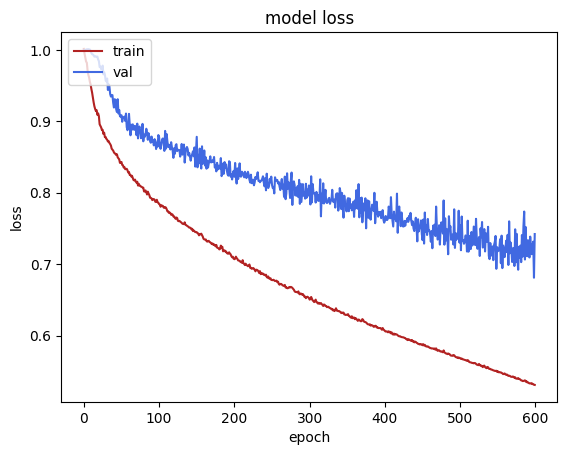

In [308]:
import matplotlib.pyplot as plt
plt.plot(historys['loss'],color='firebrick')
plt.plot(historys['val_loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

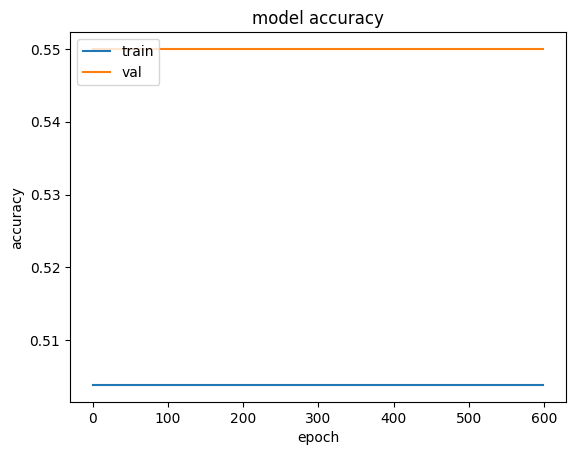

In [309]:
import matplotlib.pyplot as plt
plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# # Create directory to save models 

# save_dir = '../gict/22.07.12 V3 데이터/saved_models/'

# historys = {}
# NUM_shuf = 3
# result_list = []

# # Run each split    +
# for RUN in range(NUM_shuf):
#     with tf.device("/gpu:0"):

#         # CREATE NEW MODEL
#         model = ensemble_build_model()

#         # COMPILE NEW MODEL
#         model.compile(loss='BinaryCrossentropy',optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['acc'])


#         imgs_x     = train_DATA['MEL_Y']
#         imgs_y     = train_DATA['MEL_Z']
#         imgs_z     = train_DATA['MEL_C']
#         labels    = train_DATA['LABEL']

#         test_imgs_x    = val_DATA['MEL_Y']
#         test_imgs_y    = val_DATA['MEL_Z']
#         test_imgs_z    = val_DATA['MEL_C']
#         test_labels  = val_DATA['LABEL']

#         TRAIN      = Generator(imgs_x,imgs_y,imgs_z, labels, batch_size=16,target_size=(128,128))
#         TEST          = Generator(test_imgs_x,test_imgs_y,test_imgs_z, test_labels, batch_size=16,target_size=(128,128))
#         early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'auto')
#     #     schedulers = tf.keras.callbacks.LearningRateScheduler(scheduler)

#         # CREATE CALLBACKS
#         checkpointer = keras.callbacks.ModelCheckpoint(save_dir+'3channel_esem.h5', monitor='val_acc',verbose=1, save_best_only=True)

#         # FIT THE MODEL
#         history = model.fit_generator(TRAIN,
#         epochs=100,
#         validation_data=TEST,
#         callbacks=[checkpointer,early_stopping])

#         historys= history.history

#         # LOAD BEST MODEL to evaluate the performance of the model
#         model.load_weights("./saved_models/KCC/3channel_esem.h5")

#         results = model.evaluate_generator(TEST)
#         results = dict(zip(model.metrics_names,results))
#         print(results['acc'])
#         result_list.append(results['acc'])

In [19]:
print(result_list)
np.average(result_list)

[]


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historys['loss'],color='firebrick')
plt.plot(historys['val_loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results

## Confusion matrics

In [ ]:
import matplotlib.pyplot as plt
import sklearn

def to_one_or_zero(bool):
    return 1 if bool else 0


# test_imgs_x    = test_DATA['MFCC_X']
test_imgs_y    = test_DATA['MFCC_Y']
# test_imgs_z    = test_DATA['MFCC_Z']
test_labels  = test_DATA['LABEL']

TEST          = Generator(test_imgs_y,test_labels, batch_size=16,target_size=(32,32))
model = keras.models.load_model("./saved_models/Y_MFCC_re.h5")
y_score = model.predict(TEST)
y_scores = list(map(to_one_or_zero, y_score > .5))

con_mat = tf.math.confusion_matrix(labels=test_labels[:len(y_scores)], predictions=y_scores).numpy()
print(con_mat)

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Probability score visualization

### Origin pd

In [ ]:
with open("../project/data/experiment/ValData_Overall.pickle", 'rb') as f:
    Data = pickle.load(f) 

In [ ]:
Data

In [ ]:
Data = Data.sort_values(by=['ToolCount'],ascending=True)
Data = Data.drop(['Feature1','Feature2','Feature3','Feature4','biteCount'],axis=1)

In [ ]:
Data

### model result pd

In [ ]:
y_score_list = []
for i in y_score:
    y_score_list.append(i[0])

In [ ]:
ProdunctCount_list =[]
for i in test_imgs_y:
    num = int(i.split('/')[5].split('.')[0])
    ProdunctCount_list.append(num)

In [ ]:
resultData = pd.DataFrame(columns =['ProductCount','y_score'])

In [ ]:
resultData['ProductCount'] = ProdunctCount_list
resultData['y_score'] = y_score_list

In [ ]:
resultData

### merge pd

In [ ]:
finalData= pd.merge(Data,resultData, how='outer',on='ProductCount')
finalData = finalData.drop(['ProductCount','Label'],axis=1)

In [ ]:
finalData= pd.merge(Data,resultData, how='outer',on='ProductCount')
finalData

In [ ]:
finalDatas = finalData.groupby(['ToolCount'], as_index=False).mean()

In [ ]:
finalDatas

### visualization

In [ ]:
import matplotlib.ticker as ticker
def plot_predictscore(finalDatas):
    predictscore = finalDatas['y_score']
    ToolCount = finalDatas['ToolCount']
    plt.figure(figsize=(10,6))
    plt.plot(ToolCount,predictscore,color='lightsteelblue', marker ='o', markerfacecolor='cornflowerblue')
    plt.xlabel('ToolCount')
    plt.ylabel('y_score')
    plt.show()

In [ ]:
plot_predictscore(finalDatas)